In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
import arviz
import ipywidgets
from matplotlib import cm, pyplot
import numpy
import os
import pandas
import pathlib
import pymc3

import calibr8
import cutisplit
import retl
import robotools

import run_analysis


print(f"pymc {pymc3.__version__}")
print(f"calibr8 {calibr8.__version__}")

pymc 3.11.2
calibr8 6.0.2


In [67]:
DCS_EXPERIMENT = 'Pahpshmir_MTP-Screening-PETase'
RUN_ID = "BWA7DQ"
analyser = run_analysis.CutisplitAnalysis(DCS_EXPERIMENT, RUN_ID)
resultpath = f'{RUN_ID}_Results' 
if not os.path.isdir(resultpath):
    os.makedirs(resultpath)

## Model inputs
The model reproduces the experimental layout and dilutions of samples/standards that go into the assays.
This layout should be given in a `DataFrame`, indexed by the `input_well` ID (the DWP well) and having columns `"type"` and `"concentration_factor"`.

The `"type"` should represent the kind of sample.
`"concentration_factor"` allows you to analyze different dilutions at the same time.

In [68]:
df_inputs = analyser.get_df_inputs().dropna()
df_inputs.head()

type concentration_factor
input_well                           
B01          Bsn                    1
B02         CwlS                    1
B03          Vpr                    1
B04         YwaD                    1
B05         YolA                    1

We'll need at least one dataset - Cutinase, split-GFP or both.
The cutinase dataset should be represented as a DataFrame:

In [69]:
df_cutinase = analyser.get_df_cutinase()
df_cutinase.head()

time   value
well cycle                  
A01  1      0.000000  0.3684
     2      1.360983  0.3739
     3      2.721917  0.3748
     4      4.082633  0.3802
     5      5.443617  0.3844

To translate between absorbance readings and product concentration, the model needs a `calibr8` calibration model for p-Nitrophenol absorbance/concentration.

In [70]:
df_calibration = analyser.get_df_calibration()
df_calibration

concentration  absorbance
H12         0.0001      0.4502
H10         0.0001      0.4243
G12         0.0001      0.3977
G11         0.0001      0.4010
G10         0.0001      0.4186
..             ...         ...
D11         2.5000         NaN
D10         2.5000         NaN
E12         2.6000         NaN
E10         2.6000         NaN
E11         2.6000         NaN

[72 rows x 2 columns]

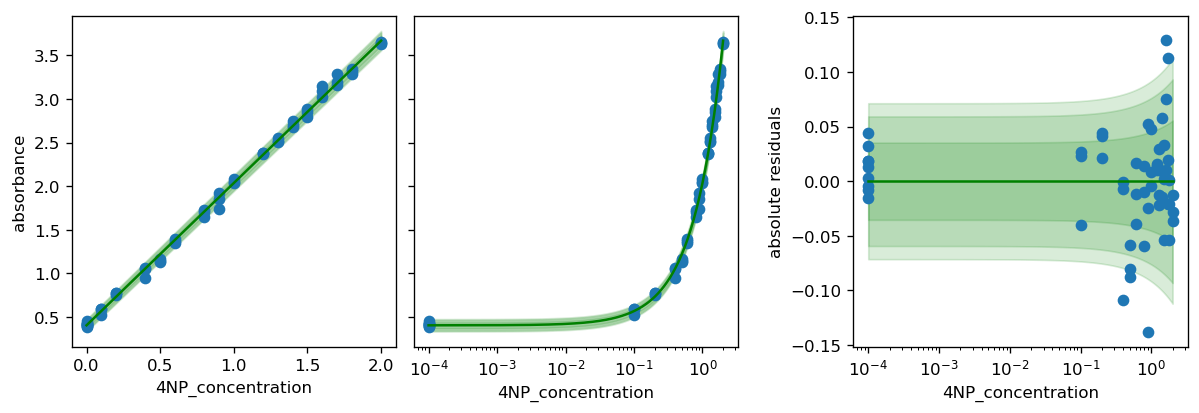

In [71]:
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel()
theta_fit, _ = calibr8.fit_scipy(
    model=cm_nitrophenol,
    independent=df_calibration.dropna().concentration.values,
    dependent=df_calibration.dropna().absorbance.values,
    theta_guess=[0.5, 2, 0.1, 0.1, 30],
    theta_bounds=[
        (0.001, 50)
    ] * len(cm_nitrophenol.theta_names)
)
cm_nitrophenol.save(fr"{resultpath}\{RUN_ID}_cm_nitrophenol.json")

fig, axs = calibr8.plot_model(cm_nitrophenol)
pyplot.show()

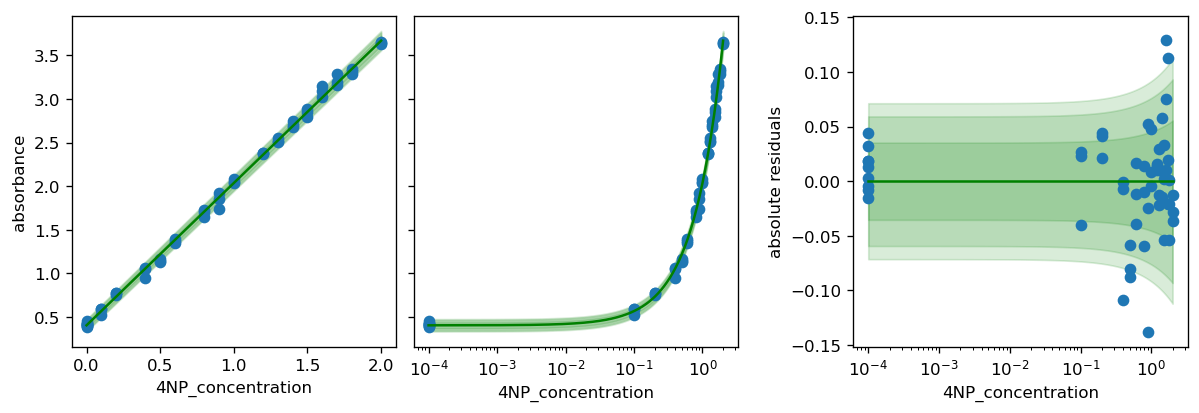

In [72]:
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel.load(rf"{resultpath}\{RUN_ID}_cm_nitrophenol.json")
calibr8.plot_model(cm_nitrophenol);

## Creating the Model
The model is initialized from the `df_inputs` that explains the structure of the dataset, plus the observations from cutinase assay, split-GFP assay or both.

In [73]:
model = cutisplit.CombinedModel(
    df_inputs,
    df_cutinase=df_cutinase,
    cm_nitrophenol=cm_nitrophenol,
    df_sgfp=None,
    sd_sgfp=1
)
# the shapes of the dataset are encoded in the "coords" of the underlying PyMC3 model:
model.summary()

type                (24,)	AbnA, AmyE, AprE, …, YwmC
input_well          (24,)	B01, B02, B03, …, G06
assay_well          (48,)	B01, B02, B03, …, G12
cutinase_cycle      (30,)	0, 1, 2, …, 29


The PyMC3 model can be visualized as a graph:

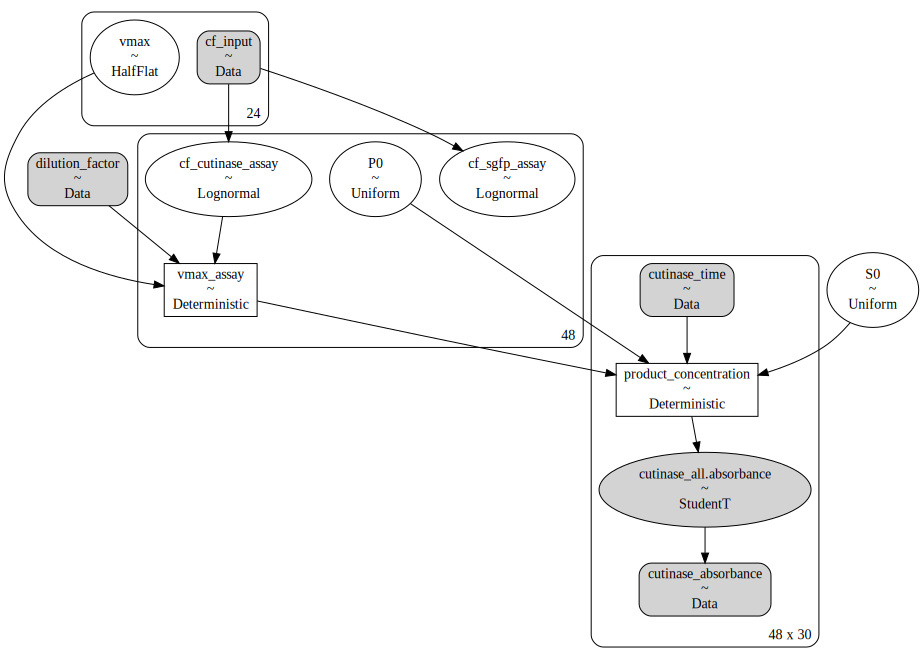

In [74]:
pymc3.model_to_graphviz(model.pmodel)

In [75]:
with model.pmodel:
    idata = pymc3.sample(return_inferencedata=True, target_accept=0.9)
idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [S0, P0, vmax, cf_sgfp_assay, cf_cutinase_assay]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

The result should be saved such that the analysis can run in another notebook.

In [76]:
idata.to_netcdf(fr"{resultpath}\{RUN_ID}_result_exponential.nc") 

PermissionError: [Errno 13] Permission denied: b'C:\\Users\\helleckes\\Repos\\cutisplit\\notebooks\\BWA7DQ_Results\\BWA7DQ_result_exponential.nc'

Execute the next cell in case you want to reload saved data

In [84]:
idata = arviz.from_netcdf(fr"{resultpath}\{RUN_ID}_result.nc")
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

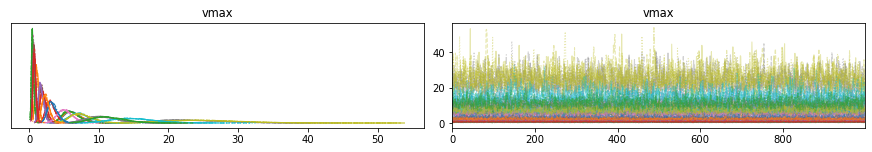

In [85]:
# For every "type" there is a vmax and fmax result:
arviz.plot_trace(idata, var_names=["vmax"]);
# The left subplots show the posterior probability density.
# The right subplots show the MCMC. If they look like random noise everything is fine.
# The linestyle corresponds to independent MCMC chains - they should come to the same result.

In [86]:
# local vars to make code more readable:
posterior = idata.posterior.stack(sample=("chain", "draw"))
posterior

<xarray.Dataset>
Dimensions:                (assay_well: 48, sample: 4000, type: 24, cutinase_cycle: 30)
Coordinates:
  * assay_well             (assay_well) object 'B01' 'B02' 'B03' ... 'G11' 'G12'
  * type                   (type) object 'AbnA' 'AmyE' 'AprE' ... 'YwaD' 'YwmC'
  * cutinase_cycle         (cutinase_cycle) int32 0 1 2 3 4 5 ... 25 26 27 28 29
  * sample                 (sample) MultiIndex
  - chain                  (sample) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw                   (sample) int64 0 1 2 3 4 5 ... 995 996 997 998 999
Data variables:
    cf_cutinase_assay      (assay_well, sample) float64 1.032 1.074 ... 1.097
    cf_sgfp_assay          (assay_well, sample) float64 1.85 0.6252 ... 1.3
    vmax                   (type, sample) float64 9.16 7.892 ... 0.6194 0.5636
    vmax_assay             (assay_well, sample) float64 0.01899 ... 0.001872
    P0                     (assay_well, sample) float64 0.03247 ... 0.0002414
    product_concentration  (assay_well, cutinase_cycle, sample) float64 0.032...
Attributes:
    created_at:                 2021-09-13T10:01:44.519070
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              125.36857080459595
    tuning_steps:               1000

In [87]:
for typ in posterior.type.values:
    print(typ)
    print(posterior.vmax.sel(type=typ).values.mean())

AbnA
6.336943444010018
AmyE
6.194877102857016
AprE
6.089268162353782
Bpr
3.128948821003242
Bsn
10.804362987258385
CwlS
1.8756363607635895
Epr
0.6227459767319257
LipA
23.13883362232487
LipB
25.48730696463431
Mpr
7.350974861057466
NprB
0.7539941342577776
NprE
1.1277024788632377
Pel
0.5106807062663803
PelB
2.0910379695629335
PhoB
1.7262223479006678
SacB
0.7394476502961659
SacC
5.237815550595593
Vpr
10.600813114781829
YncM
7.594420242559278
YoaW
15.07699401576626
YolA
3.4199669151358427
YpjP
2.4228759191048765
YwaD
11.443228789993245
YwmC
0.7999490697580762


In [88]:
idata.constant_data.cutinase_absorbance

<xarray.DataArray 'cutinase_absorbance' (assay_well: 48, cutinase_cycle: 30)>
array([[0.4589, 0.5066, 0.5413, ..., 1.6167, 1.6614, 1.7248],
       [0.4326, 0.4531, 0.4484, ..., 0.6745, 0.6866, 0.7011],
       [0.4719, 0.5118, 0.5521, ..., 1.6458, 1.6792, 1.7623],
       ...,
       [0.5514, 0.5839, 0.605 , ..., 2.1668, 2.2121, 2.272 ],
       [0.4028, 0.4039, 0.4065, ..., 0.4932, 0.4999, 0.4595],
       [0.461 , 0.457 , 0.4005, ..., 0.5311, 0.5319, 0.4871]])
Coordinates:
  * assay_well      (assay_well) object 'B01' 'B02' 'B03' ... 'G10' 'G11' 'G12'
  * cutinase_cycle  (cutinase_cycle) int32 0 1 2 3 4 5 6 ... 24 25 26 27 28 29

In [89]:
df_inputs

type concentration_factor
input_well                           
B01          Bsn                    1
B02         CwlS                    1
B03          Vpr                    1
B04         YwaD                    1
B05         YolA                    1
B06         AbnA                    1
D01         PhoB                    1
D02         LipB                    1
D03          Bpr                    1
D04         AprE                    1
D05         SacC                    1
D06         SacB                    1
E01         LipA                    1
E02          Mpr                    1
E03         PelB                    1
E04         YpjP                    1
E05         AmyE                    1
E06         NprE                    1
G01         YncM                    1
G02          Pel                    1
G03         YwmC                    1
G04         YoaW                    1
G05         NprB                    1
G06          Epr                    1

In [90]:
posterior.sel(type="LipA")

<xarray.Dataset>
Dimensions:                (assay_well: 48, sample: 4000, cutinase_cycle: 30)
Coordinates:
  * assay_well             (assay_well) object 'B01' 'B02' 'B03' ... 'G11' 'G12'
    type                   <U4 'LipA'
  * cutinase_cycle         (cutinase_cycle) int32 0 1 2 3 4 5 ... 25 26 27 28 29
  * sample                 (sample) MultiIndex
  - chain                  (sample) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw                   (sample) int64 0 1 2 3 4 5 ... 995 996 997 998 999
Data variables:
    cf_cutinase_assay      (assay_well, sample) float64 1.032 1.074 ... 1.097
    cf_sgfp_assay          (assay_well, sample) float64 1.85 0.6252 ... 1.3
    vmax                   (sample) float64 17.21 17.96 19.21 ... 21.08 22.83
    vmax_assay             (assay_well, sample) float64 0.01899 ... 0.001872
    P0                     (assay_well, sample) float64 0.03247 ... 0.0002414
    product_concentration  (assay_well, cutinase_cycle, sample) float64 0.032...
Attributes:
    created_at:                 2021-09-13T10:01:44.519070
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              125.36857080459595
    tuning_steps:               1000

C:\Users\HELLEC~1\AppData\Local\Temp/ipykernel_4248/738483773.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = pyplot.subplots(


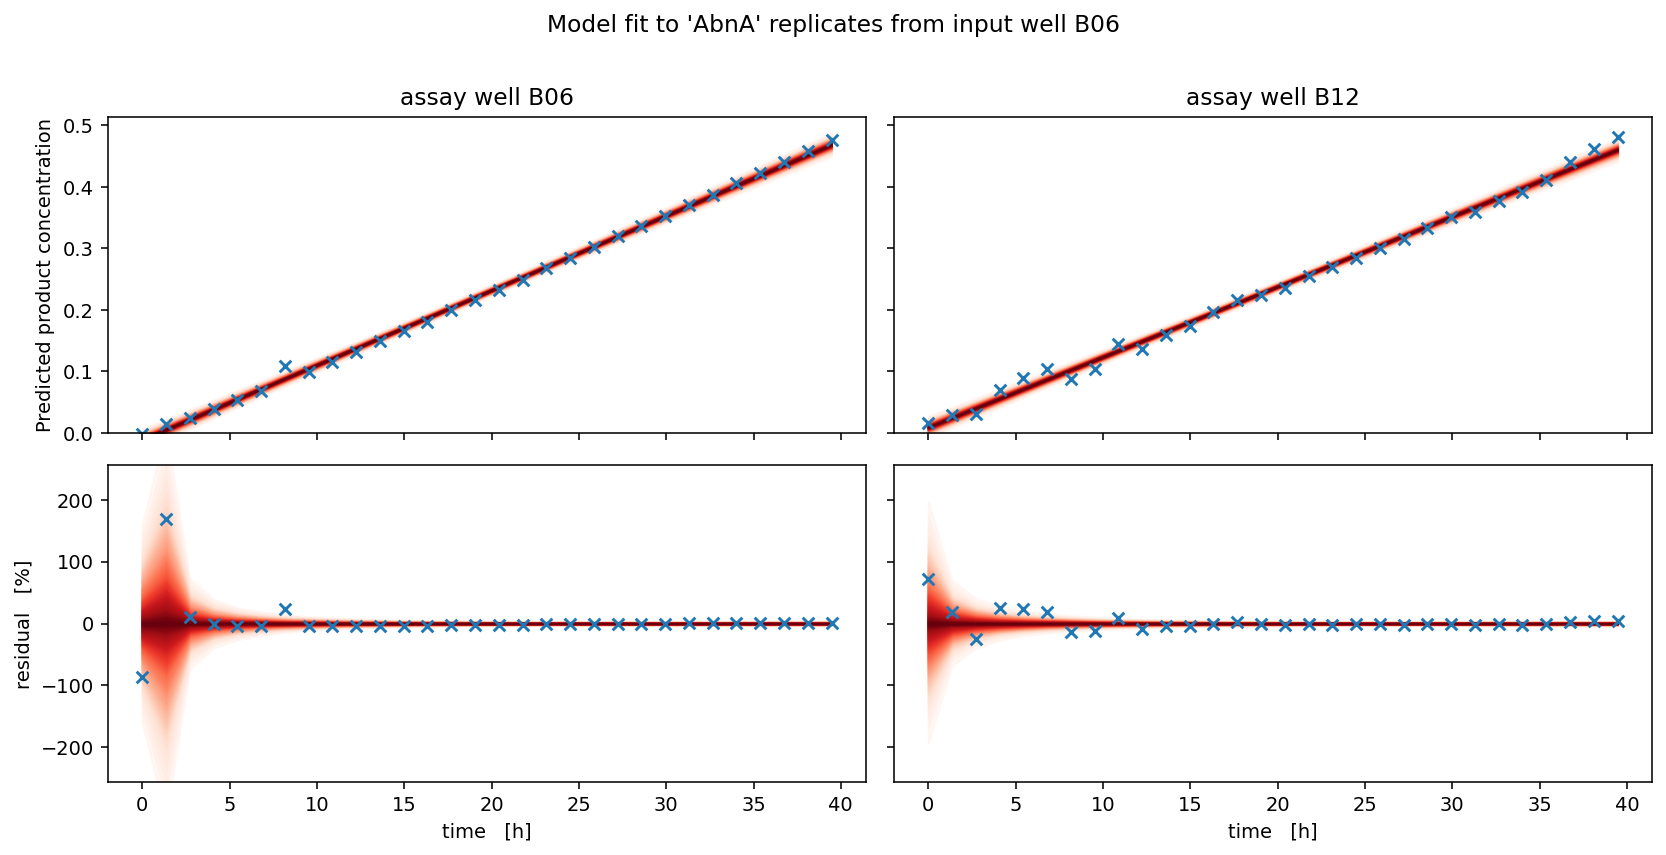

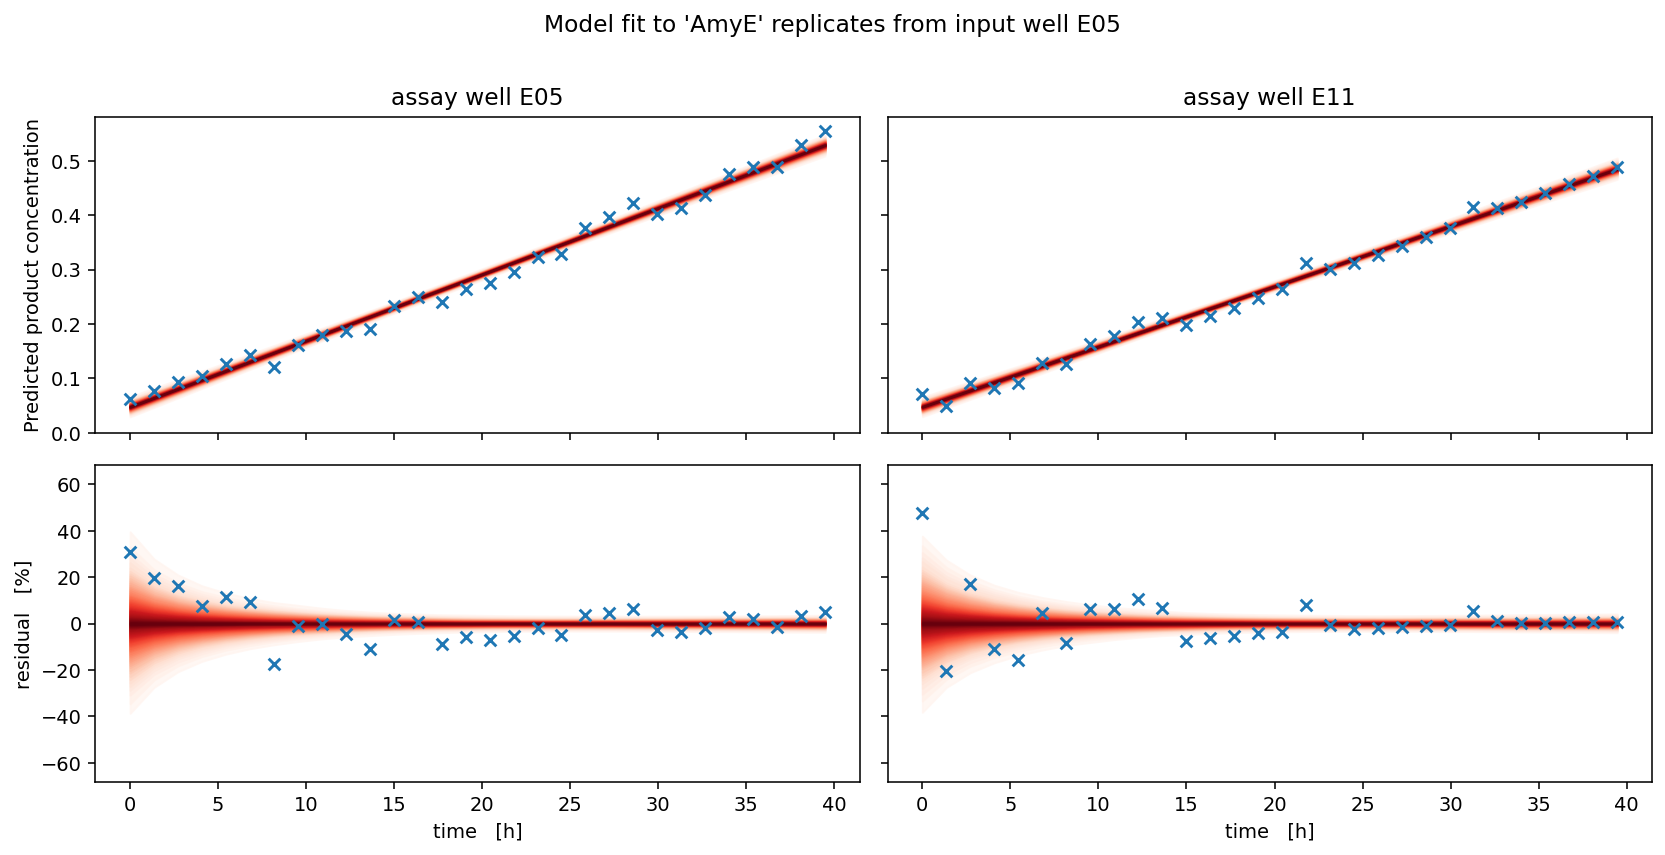

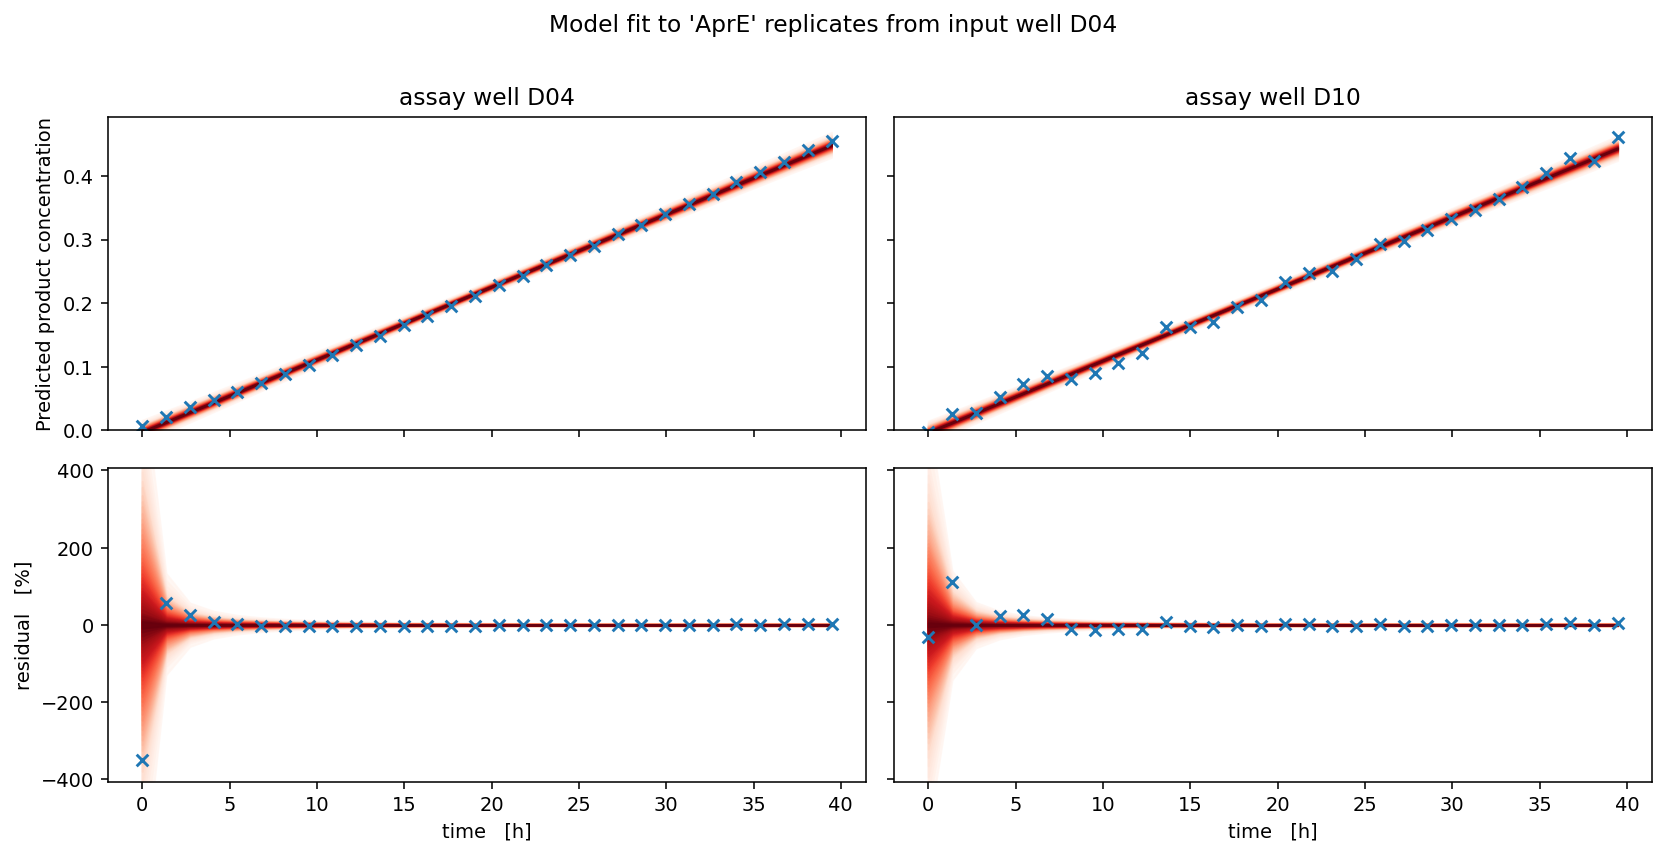

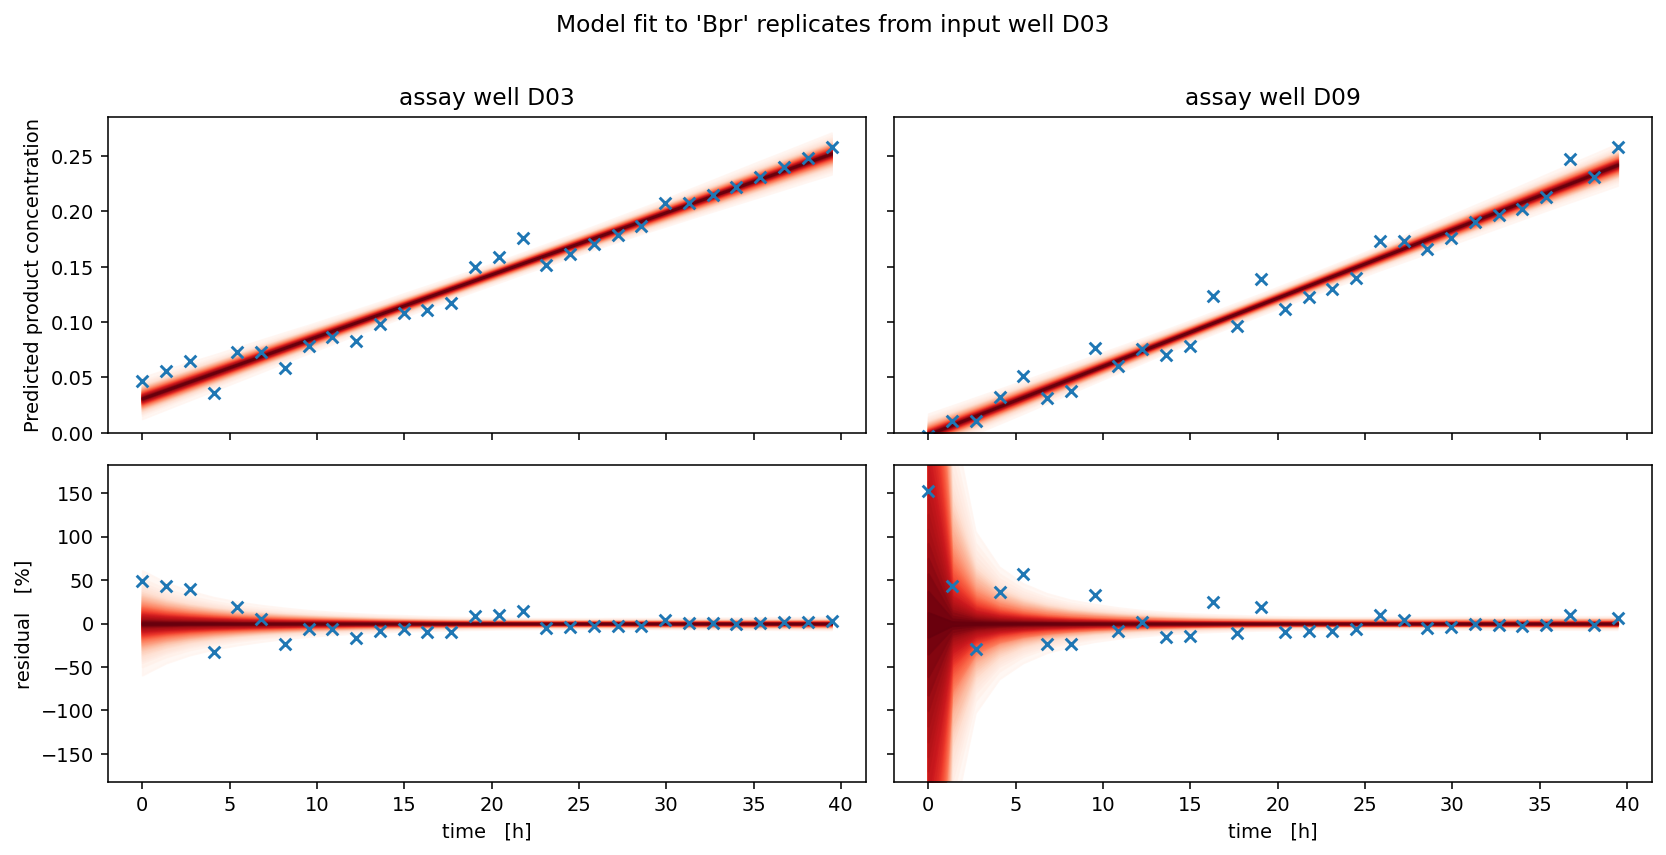

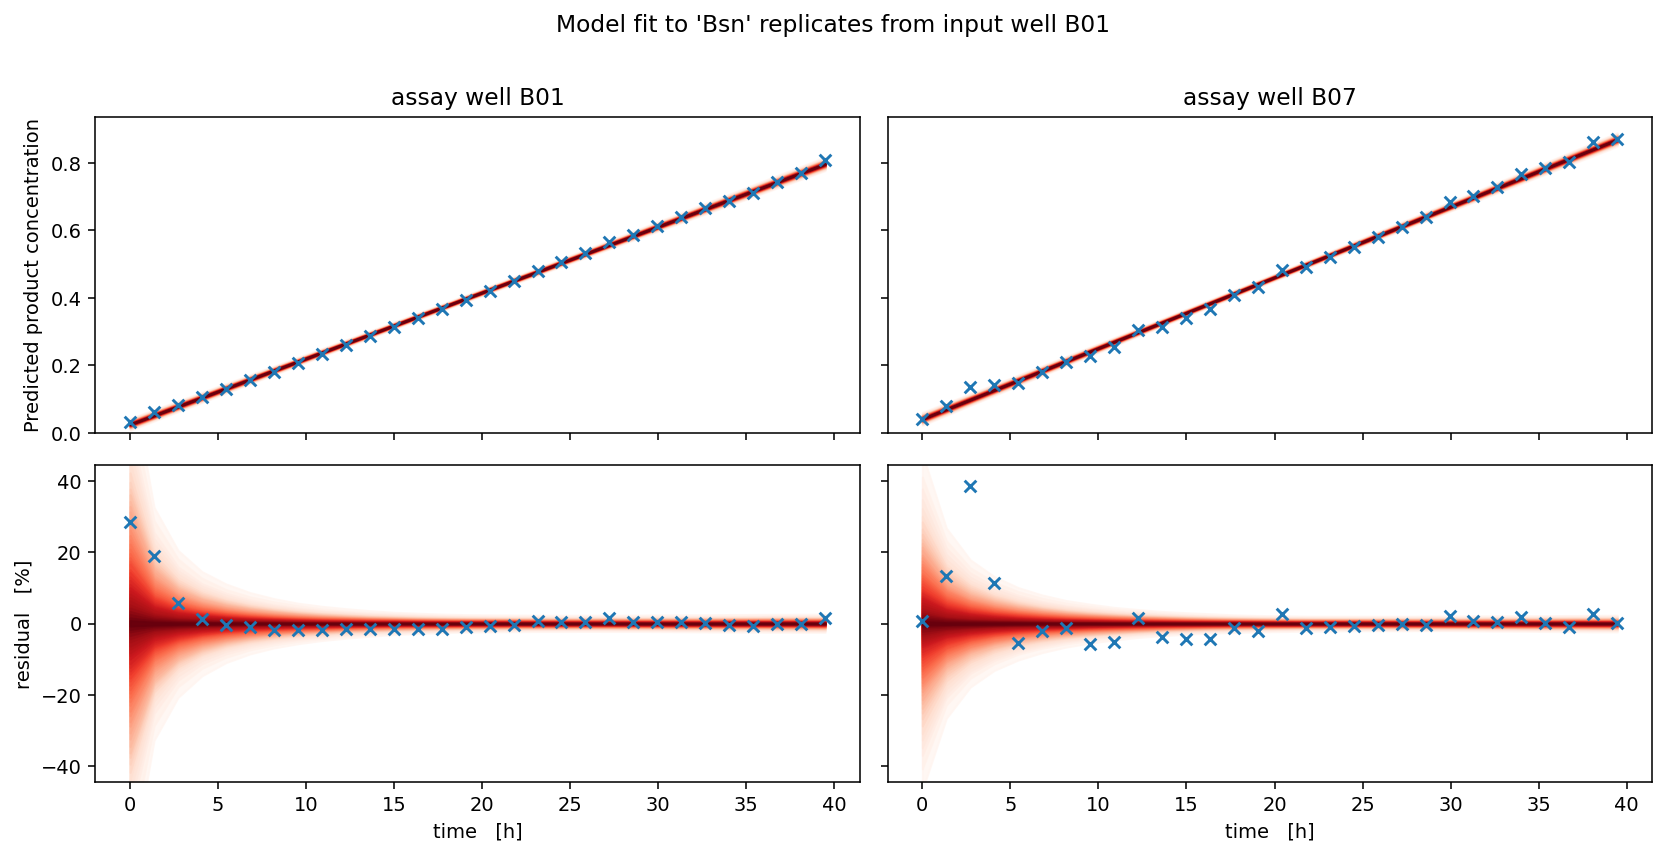

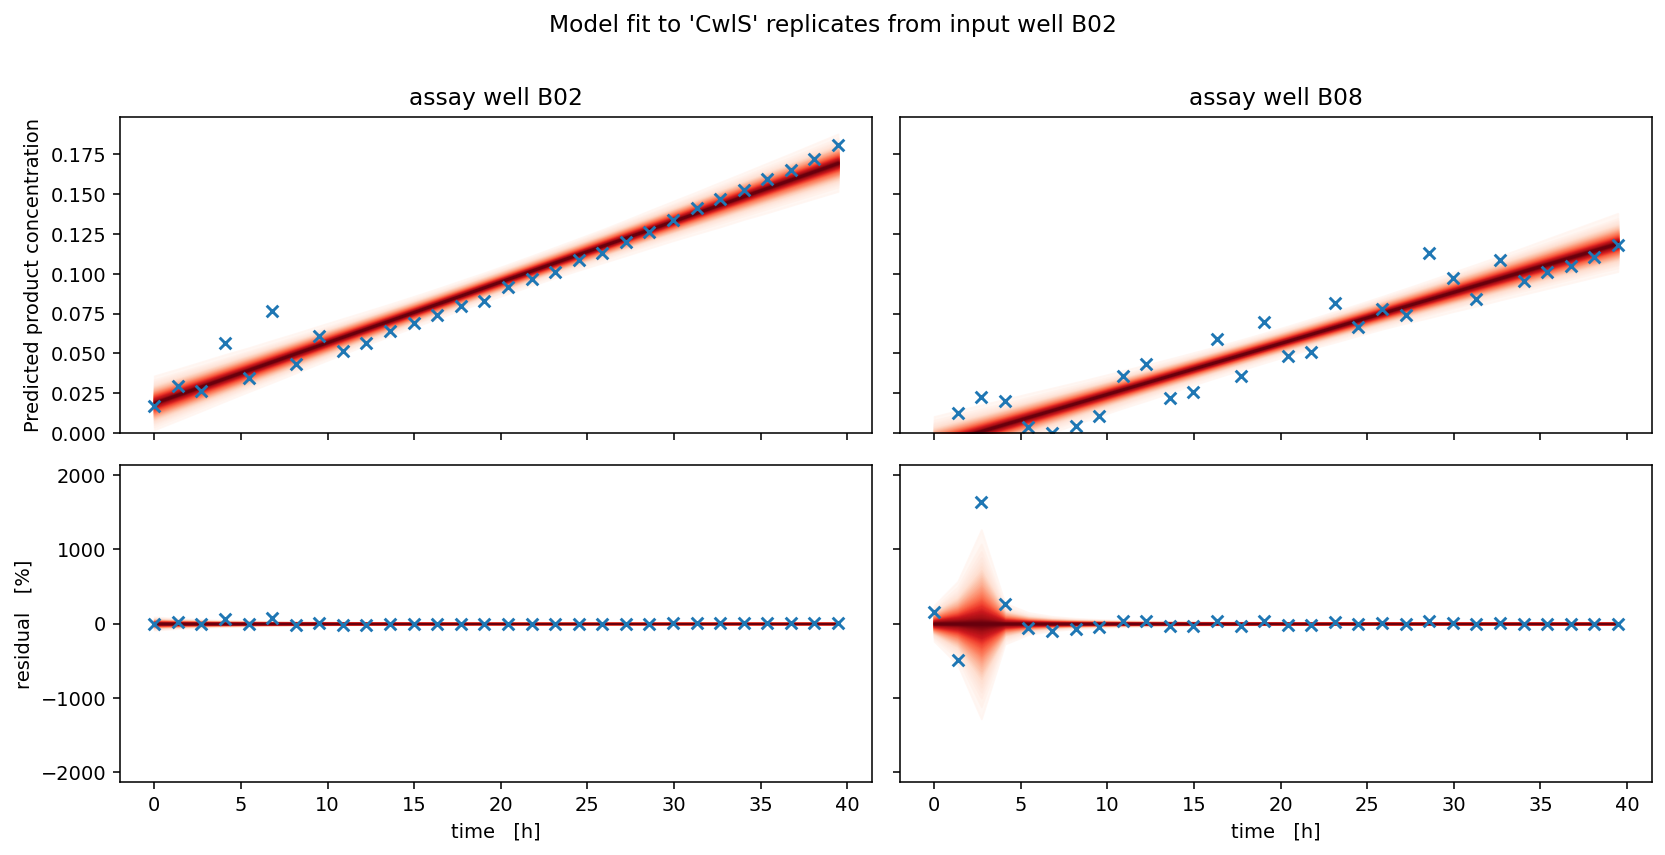

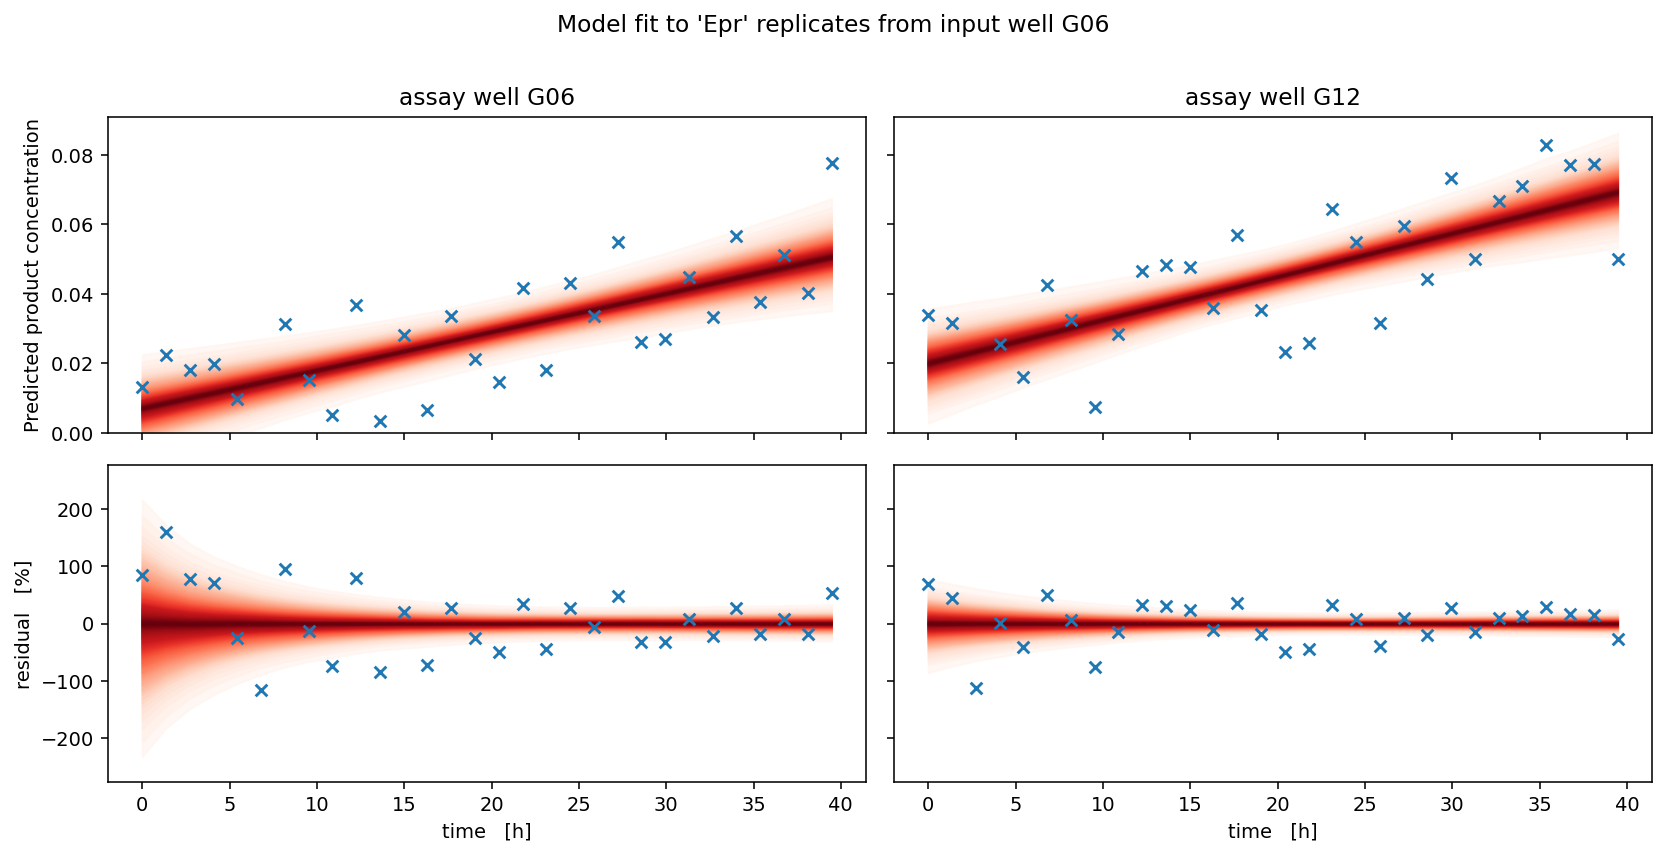

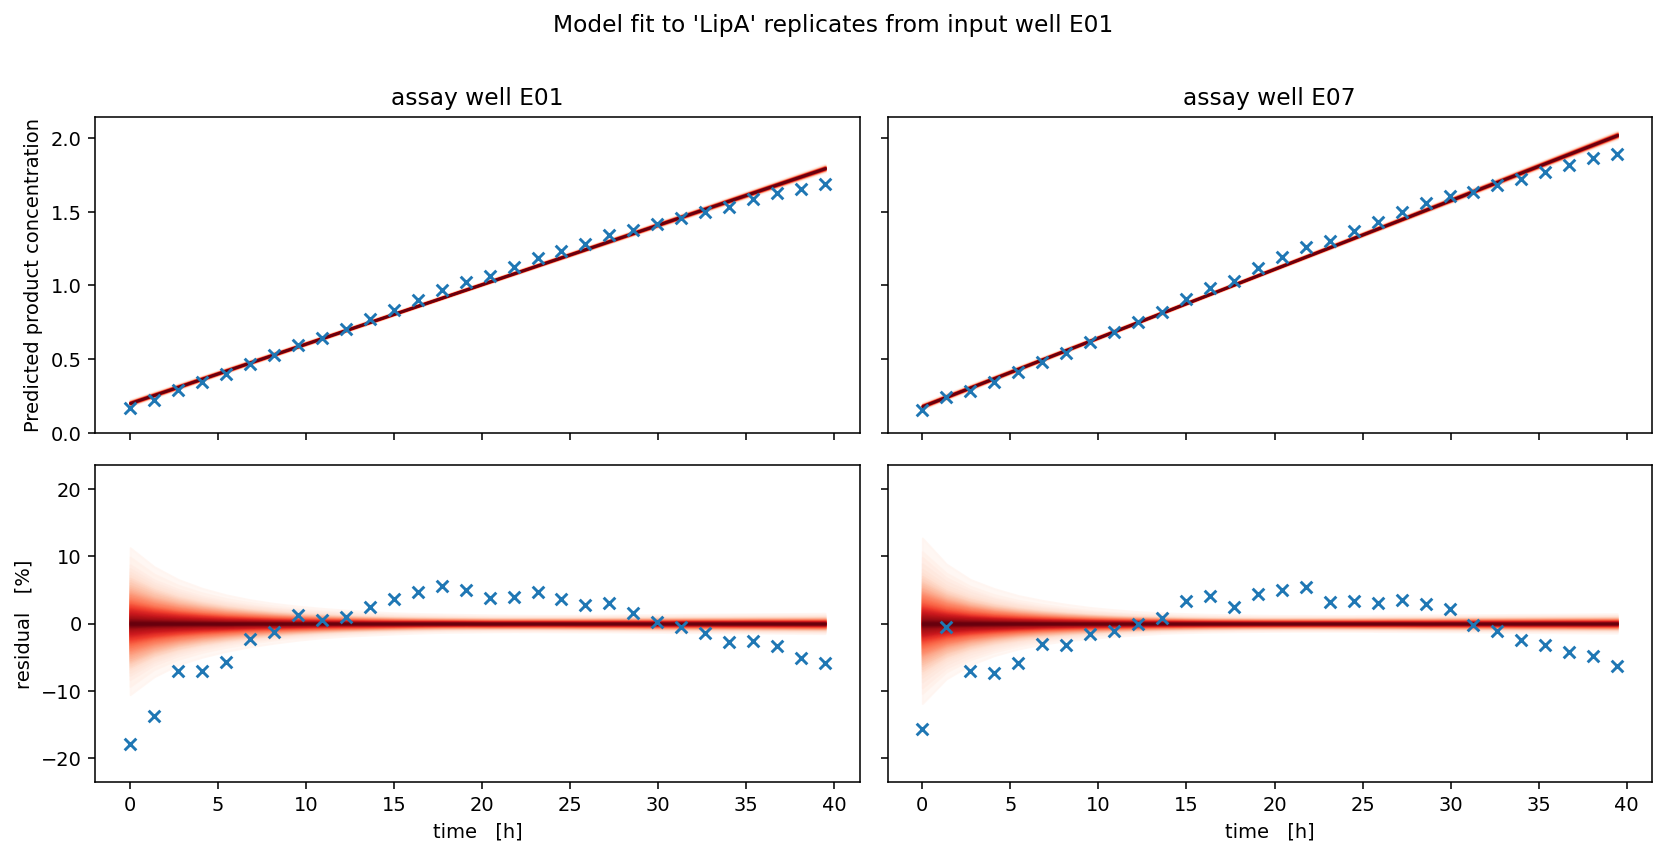

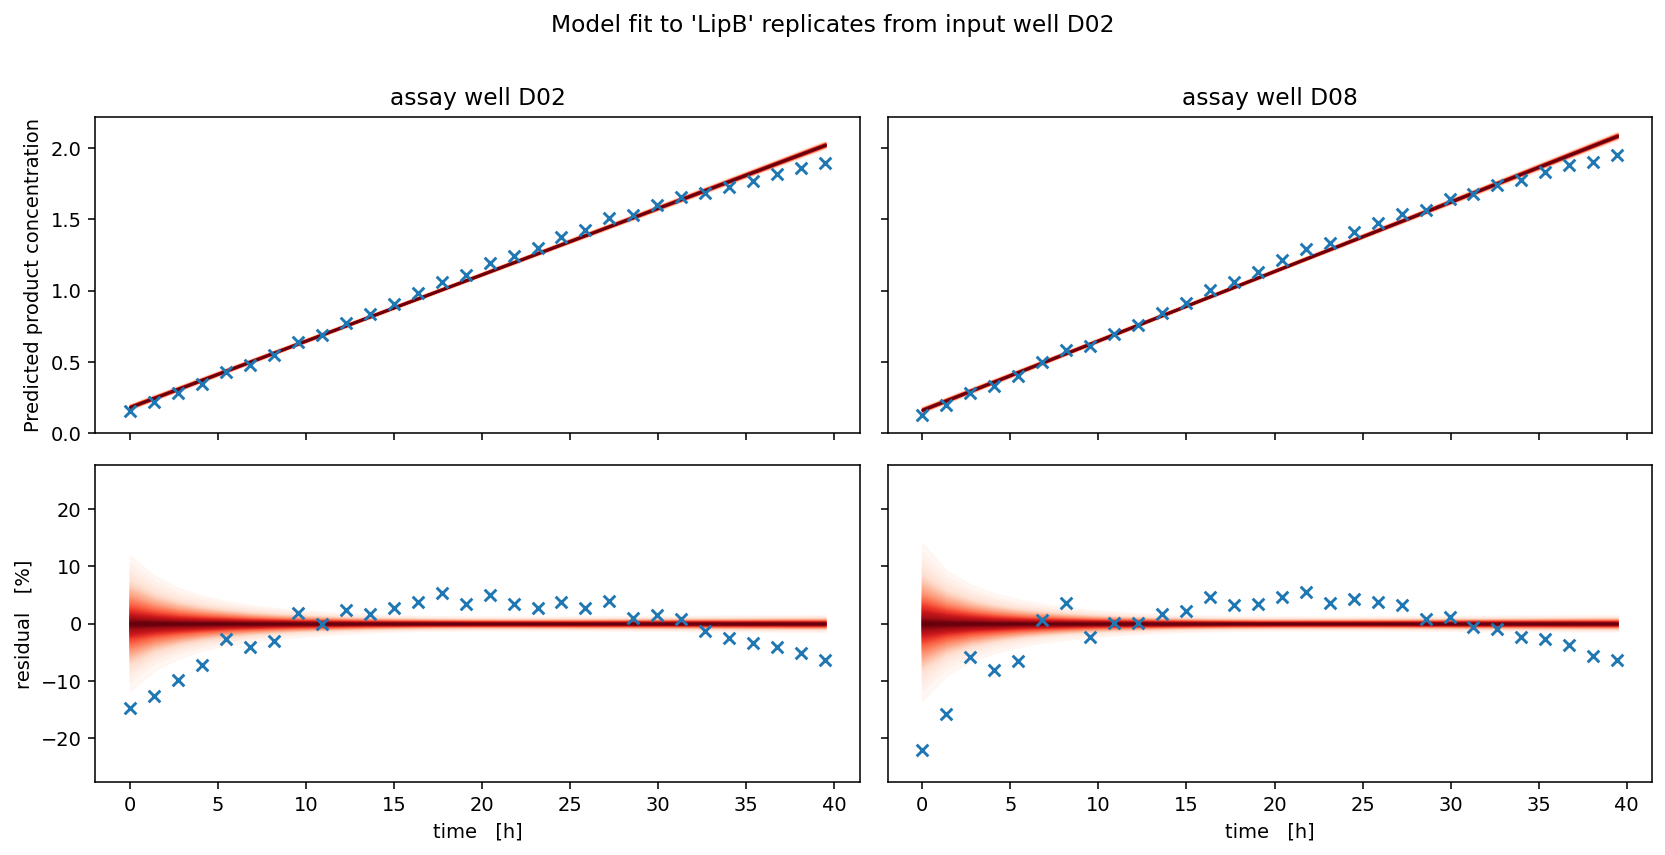

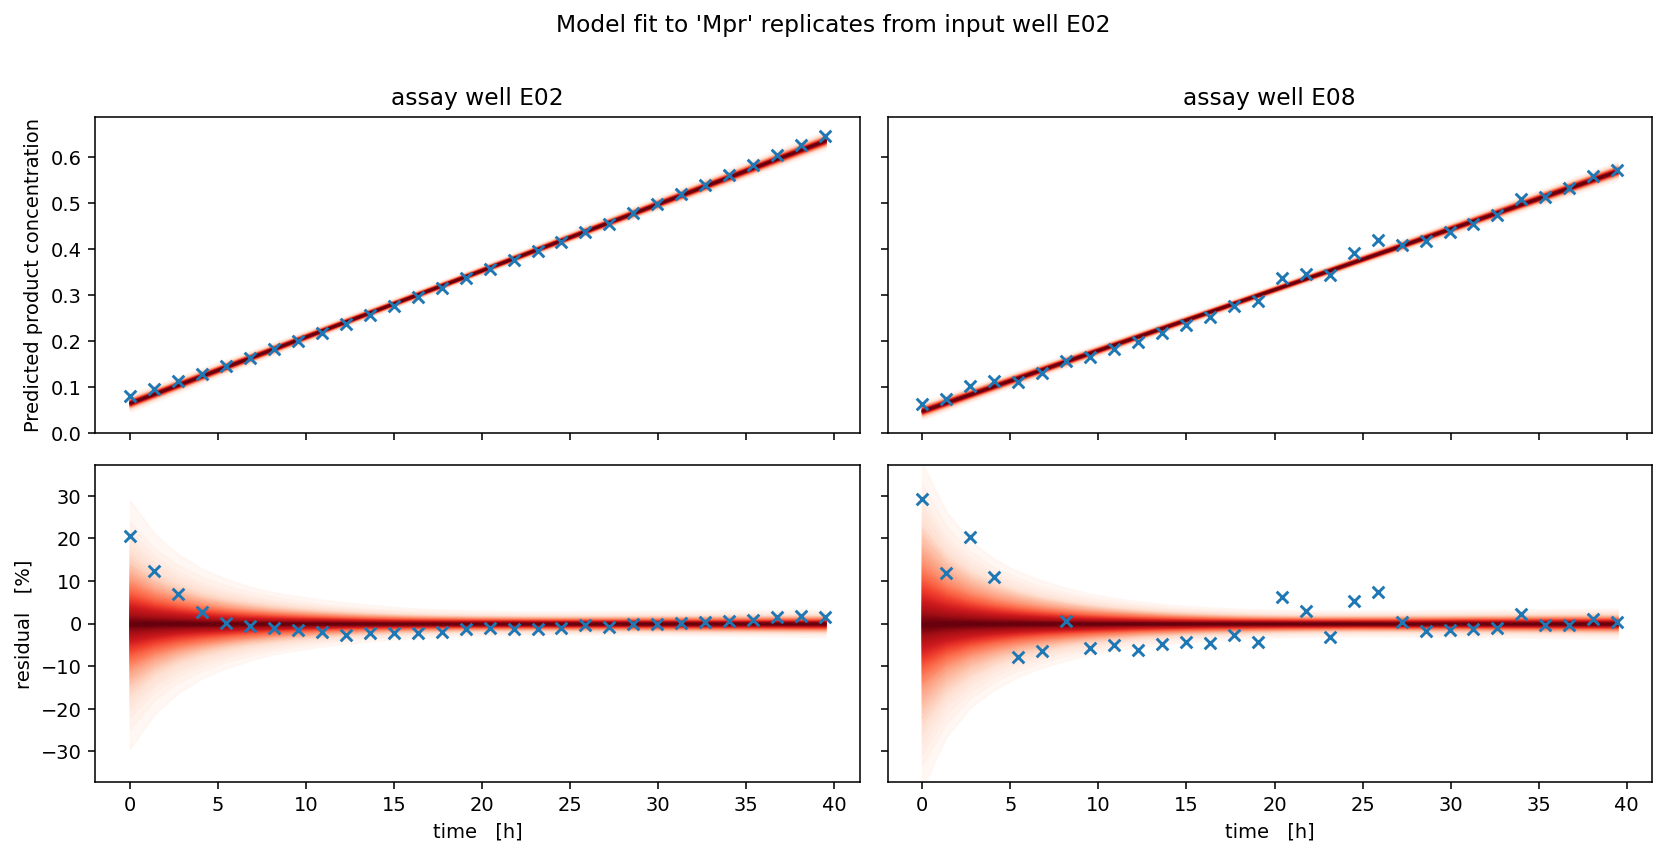

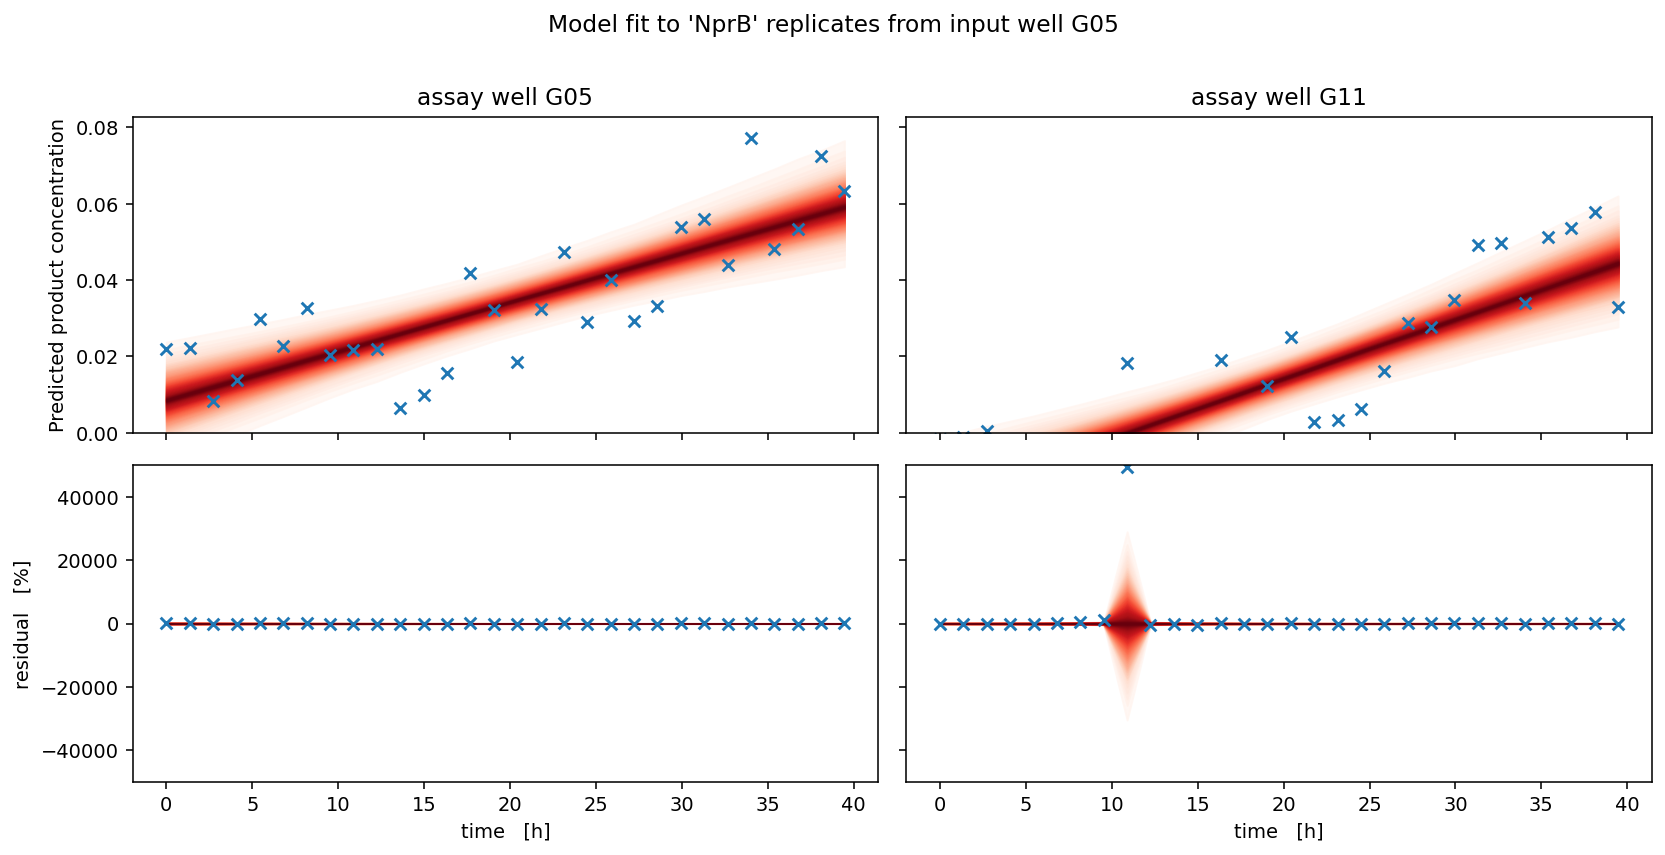

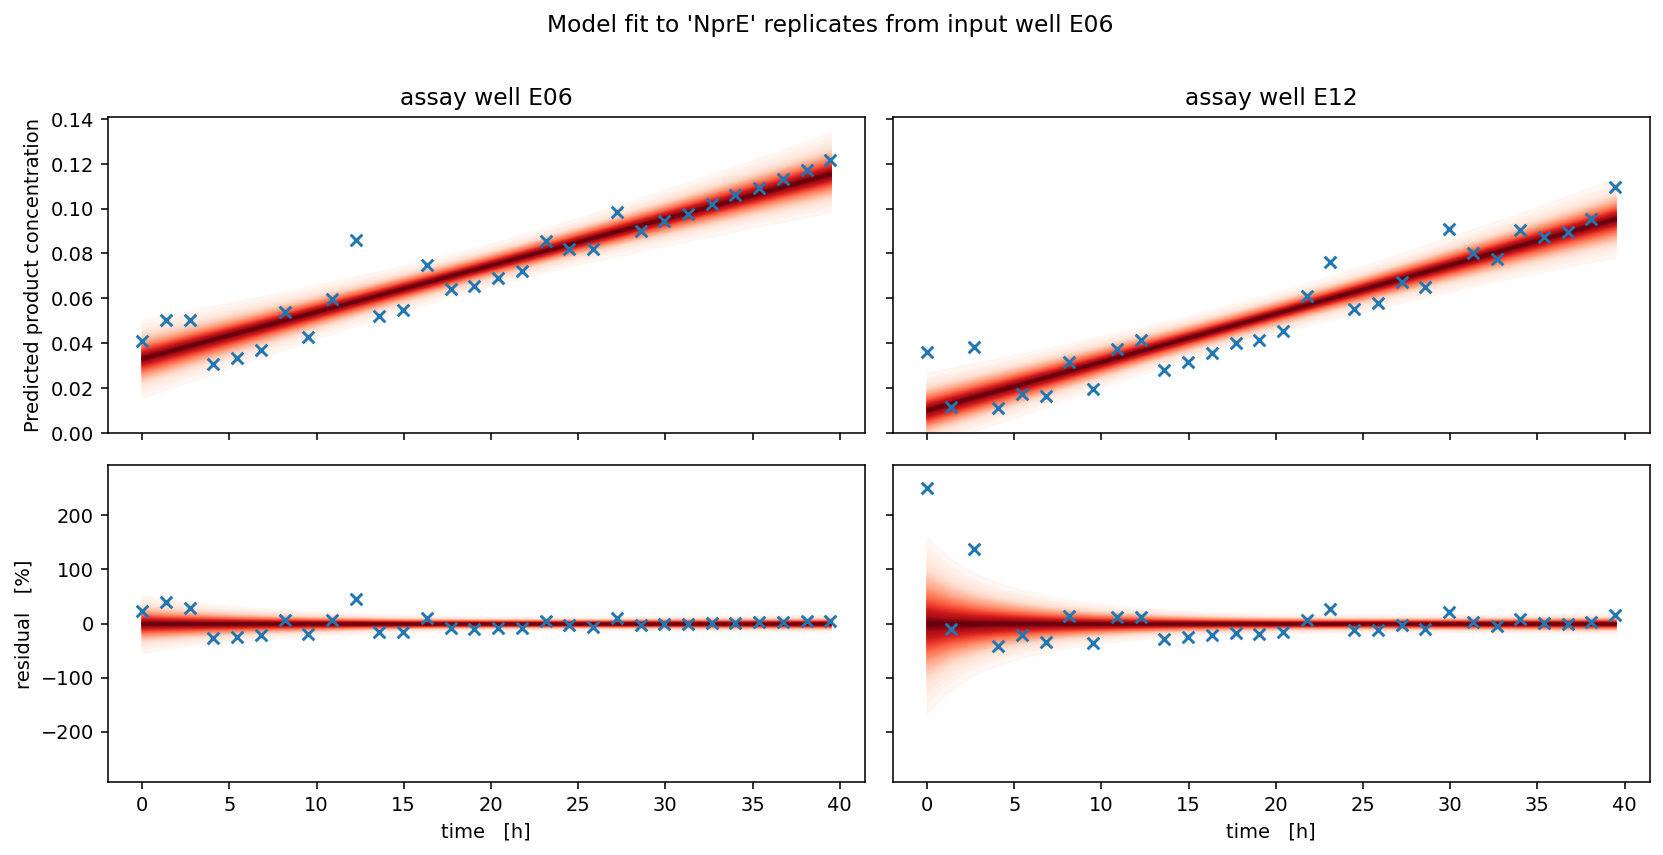

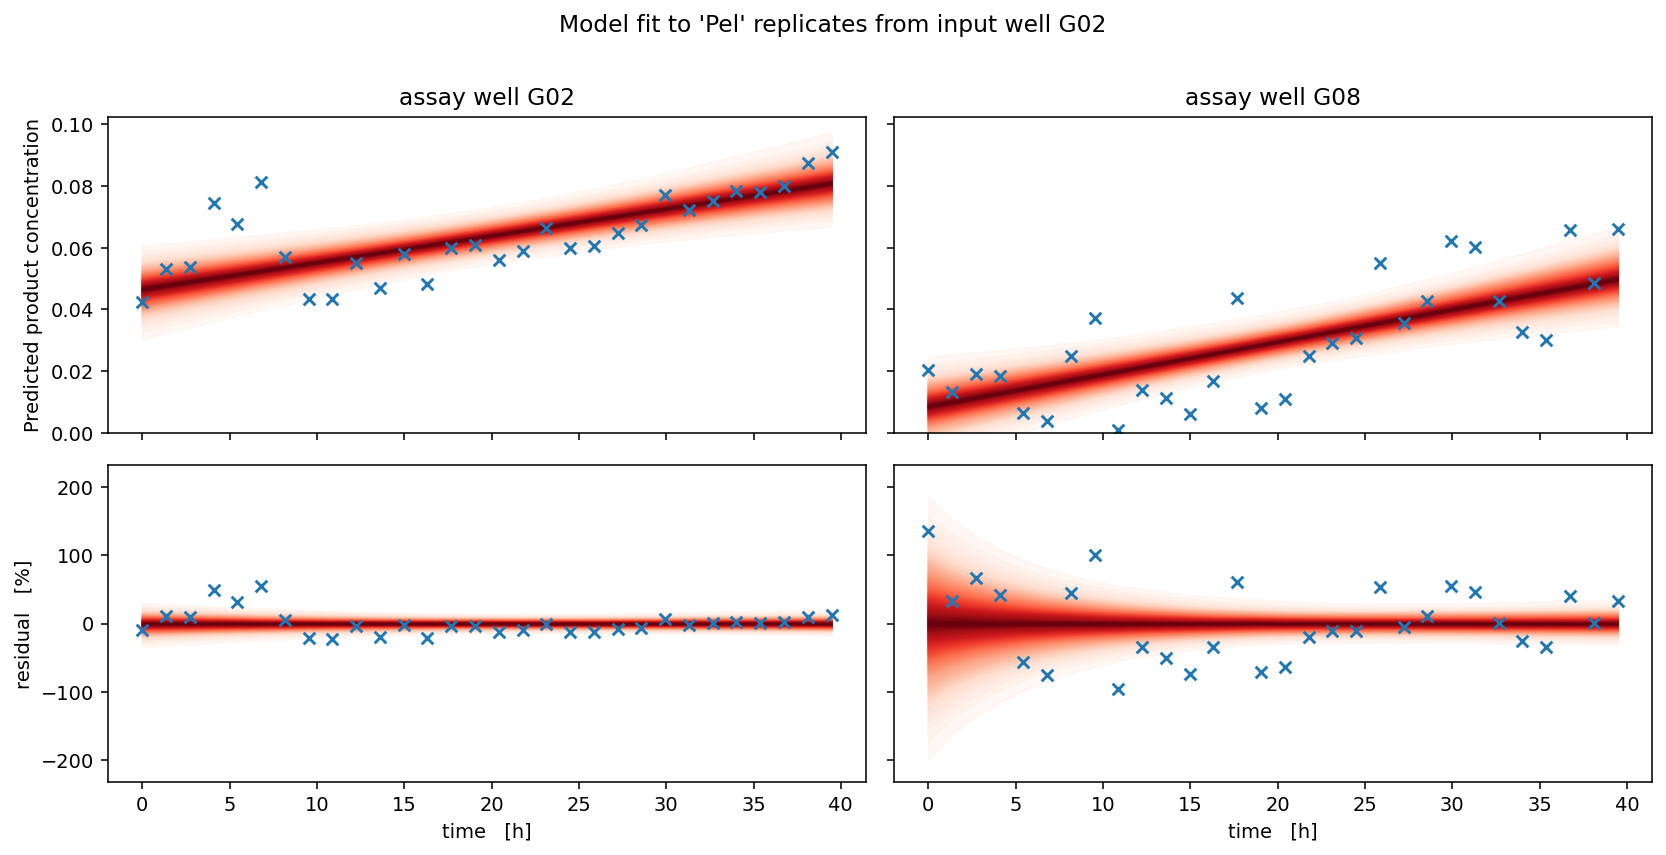

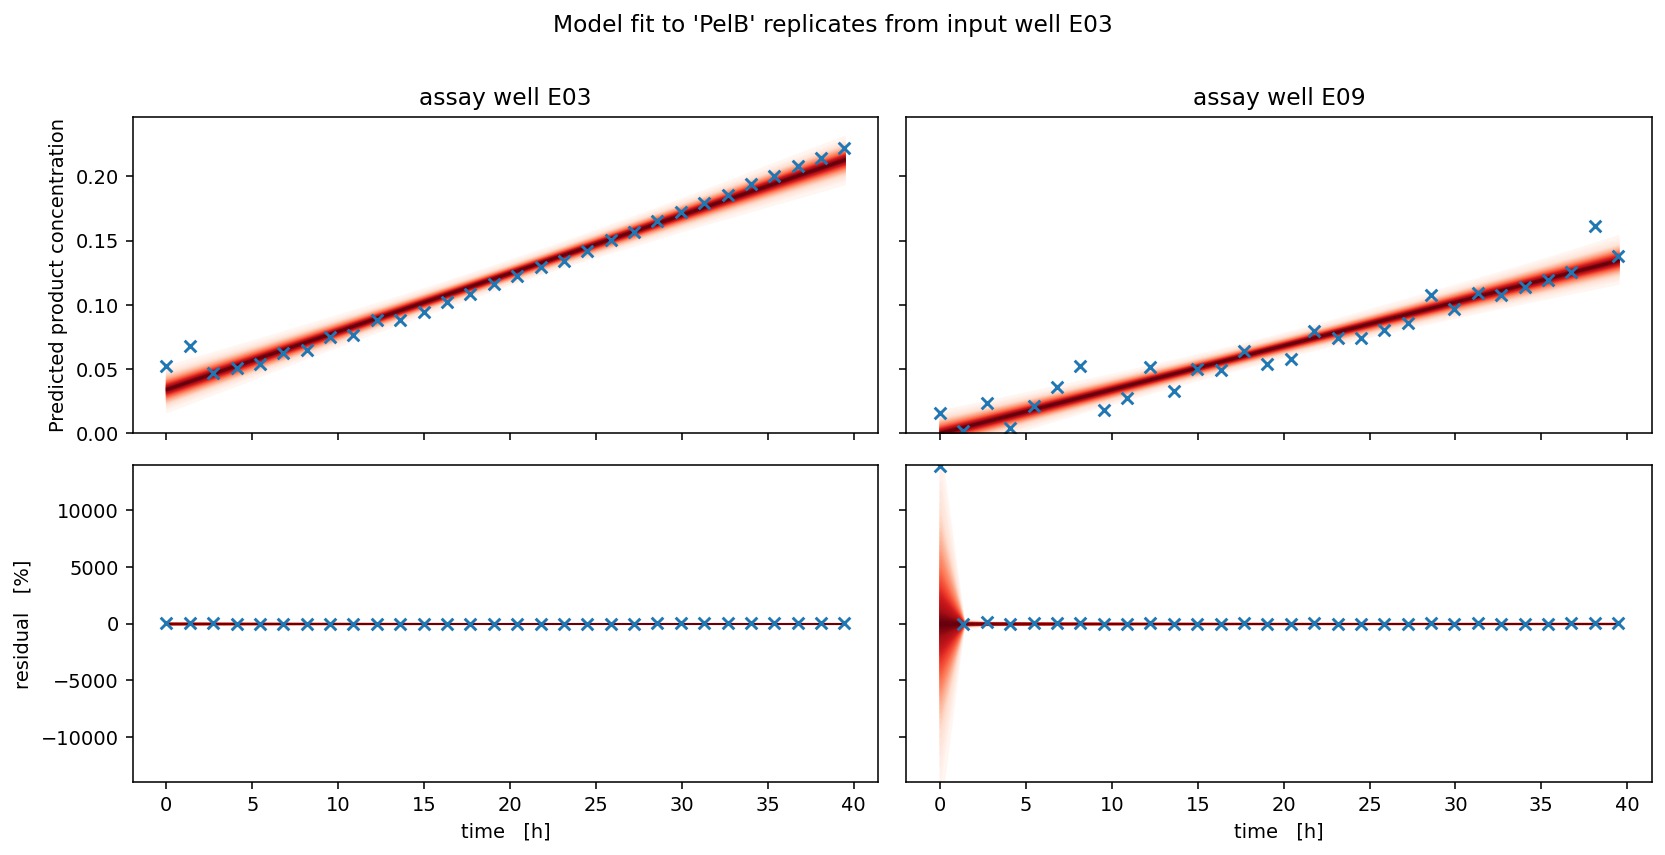

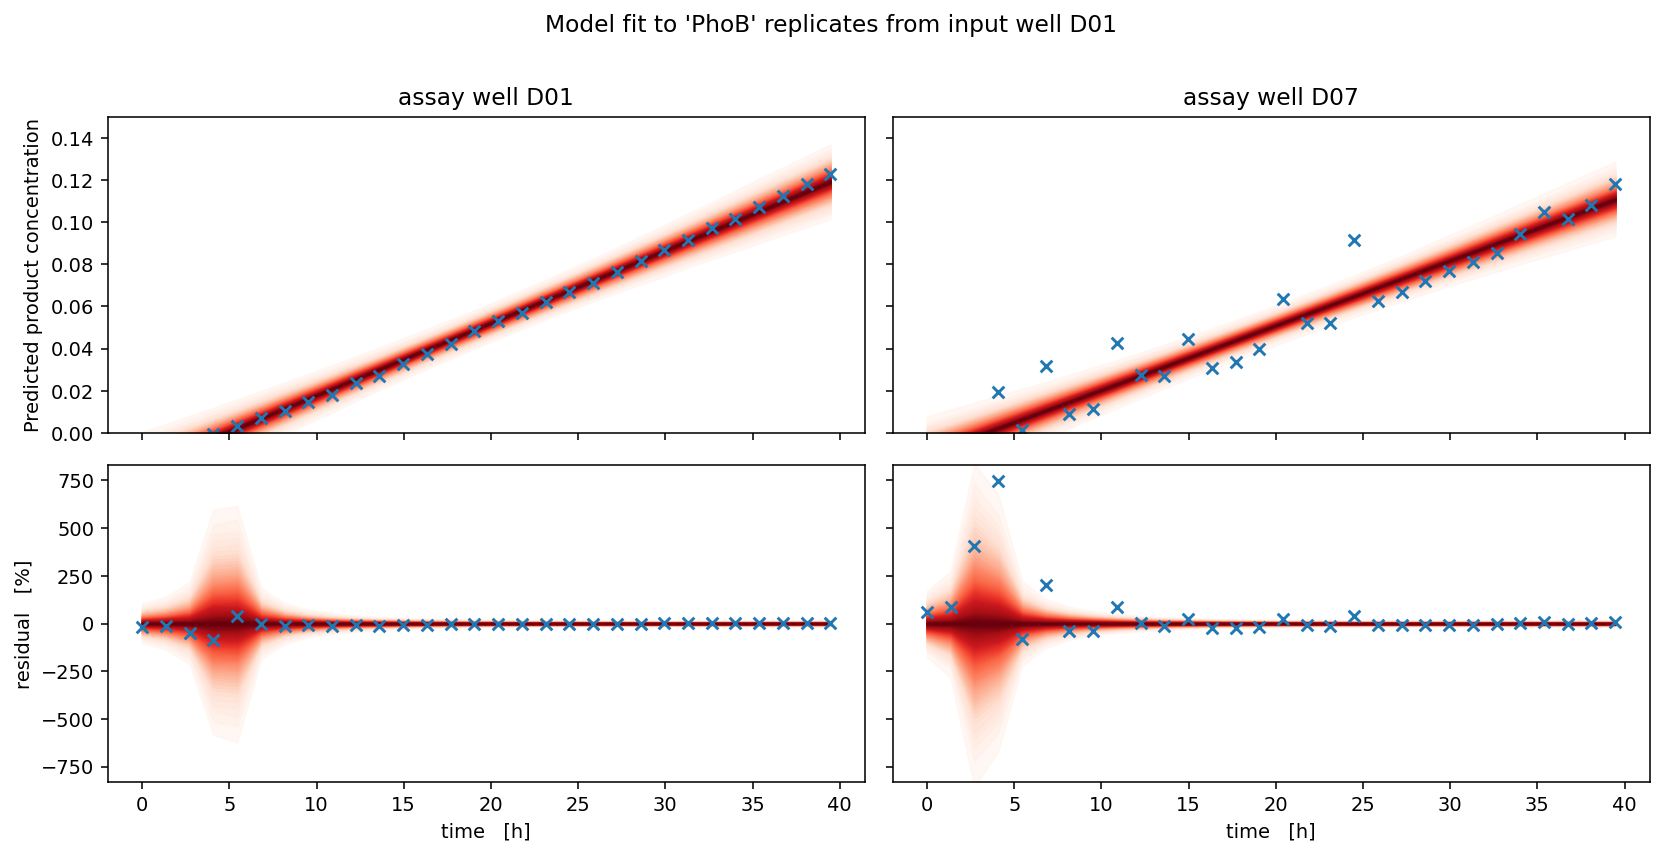

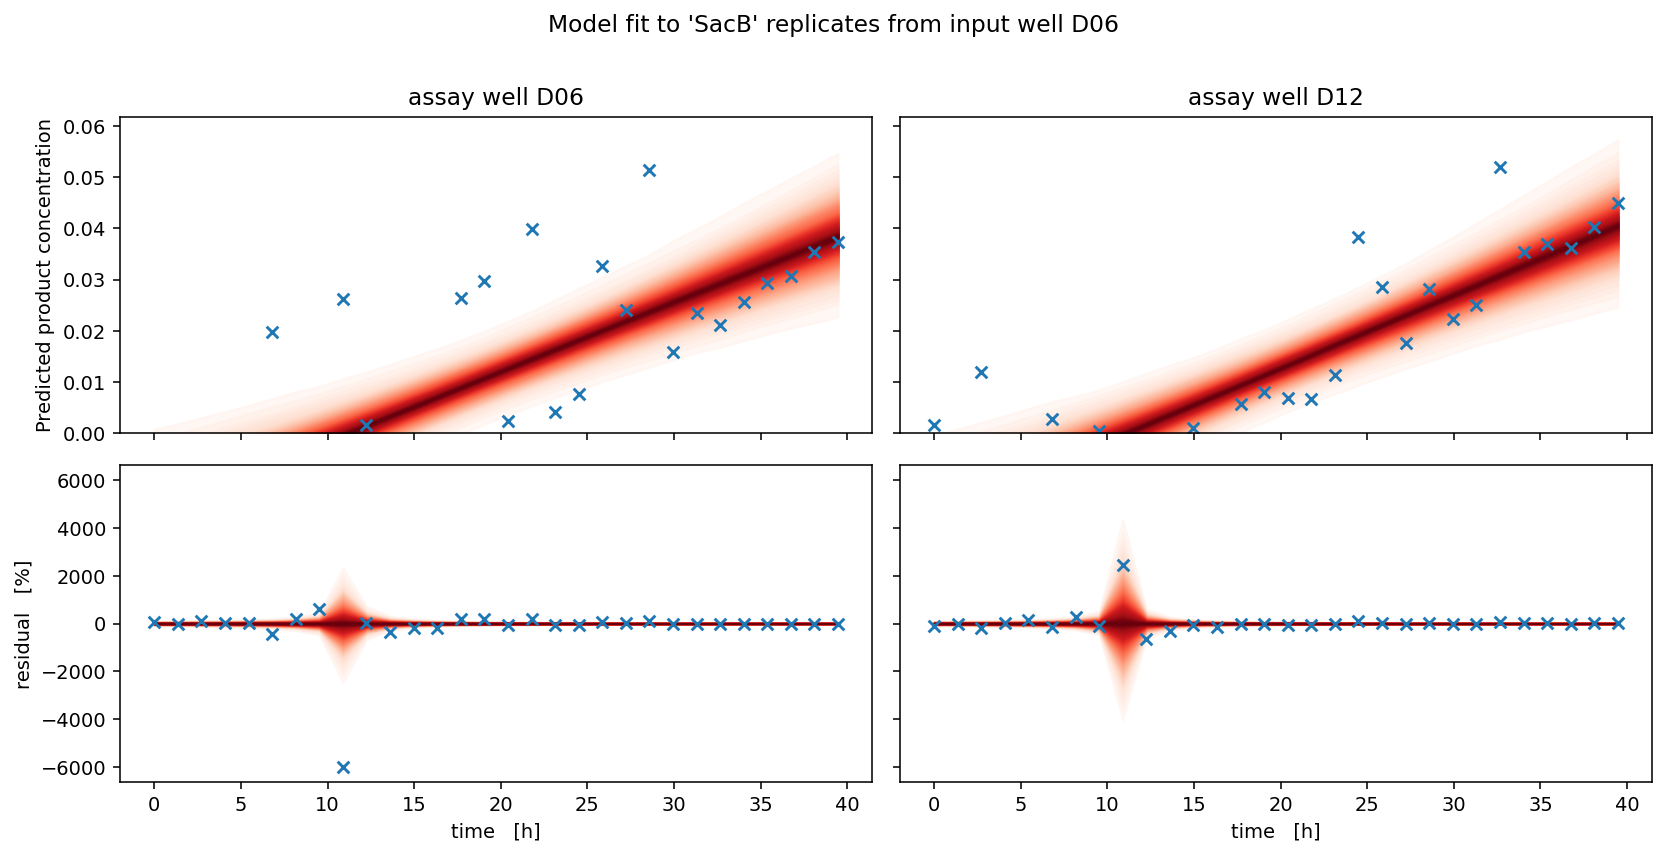

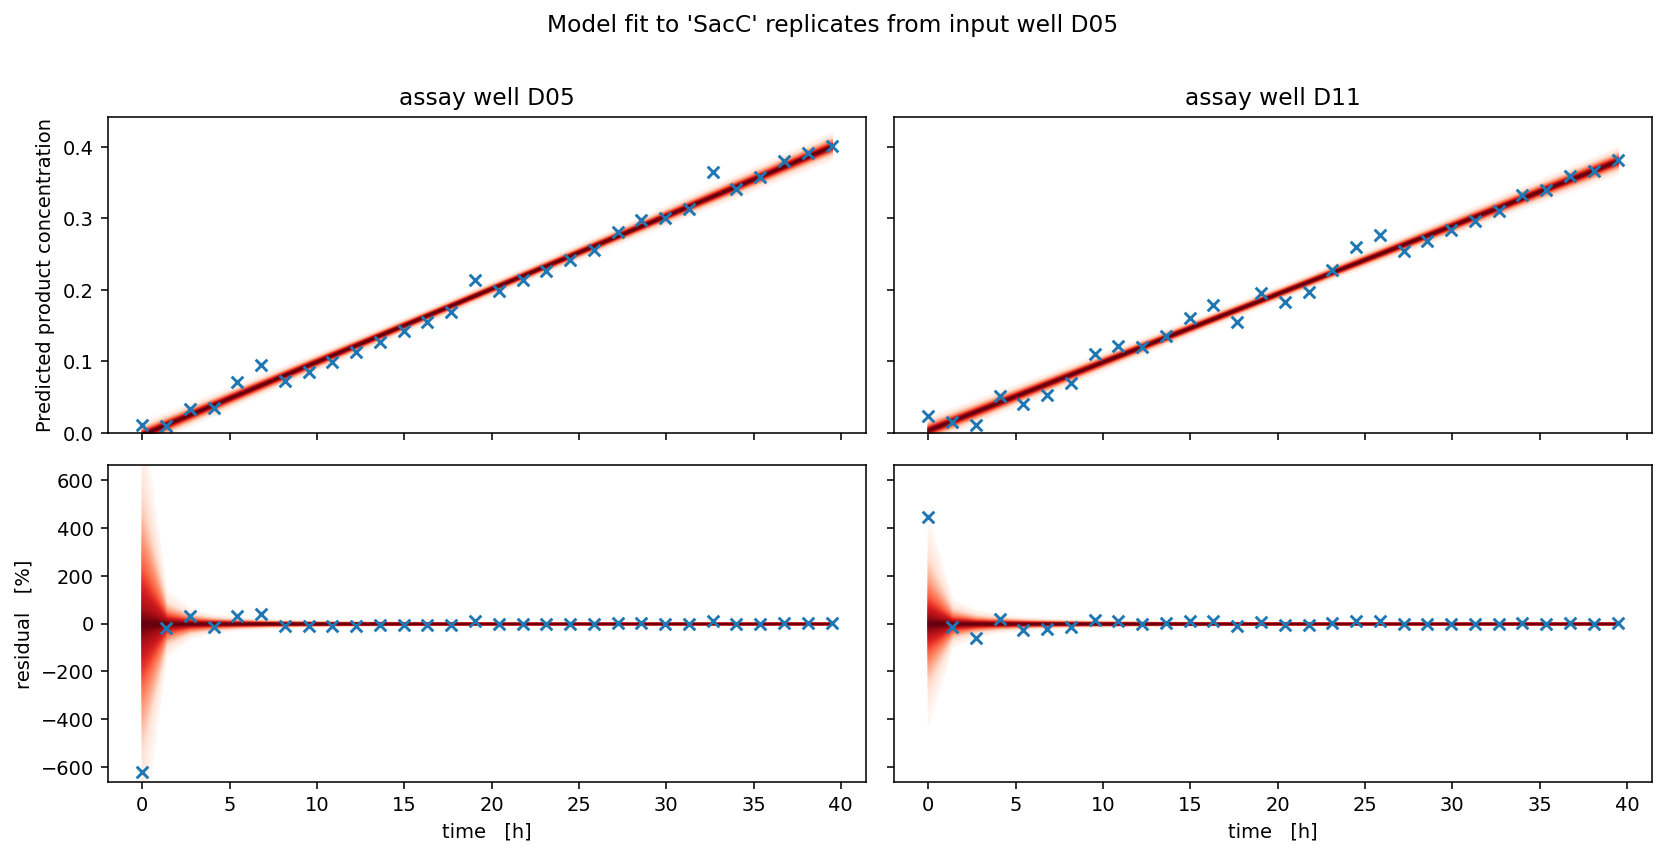

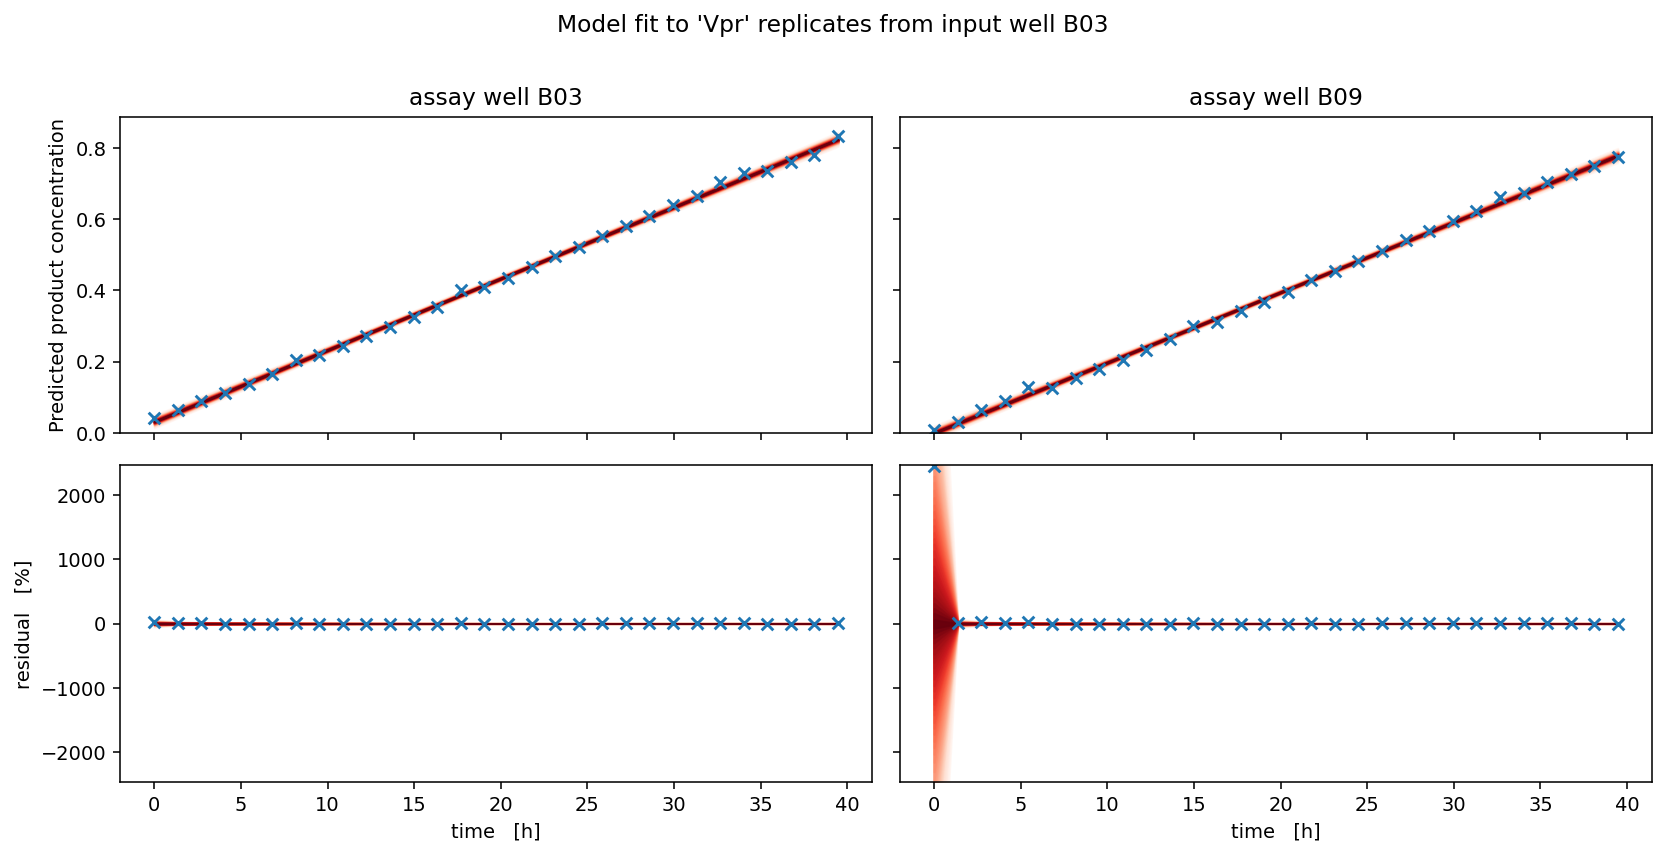

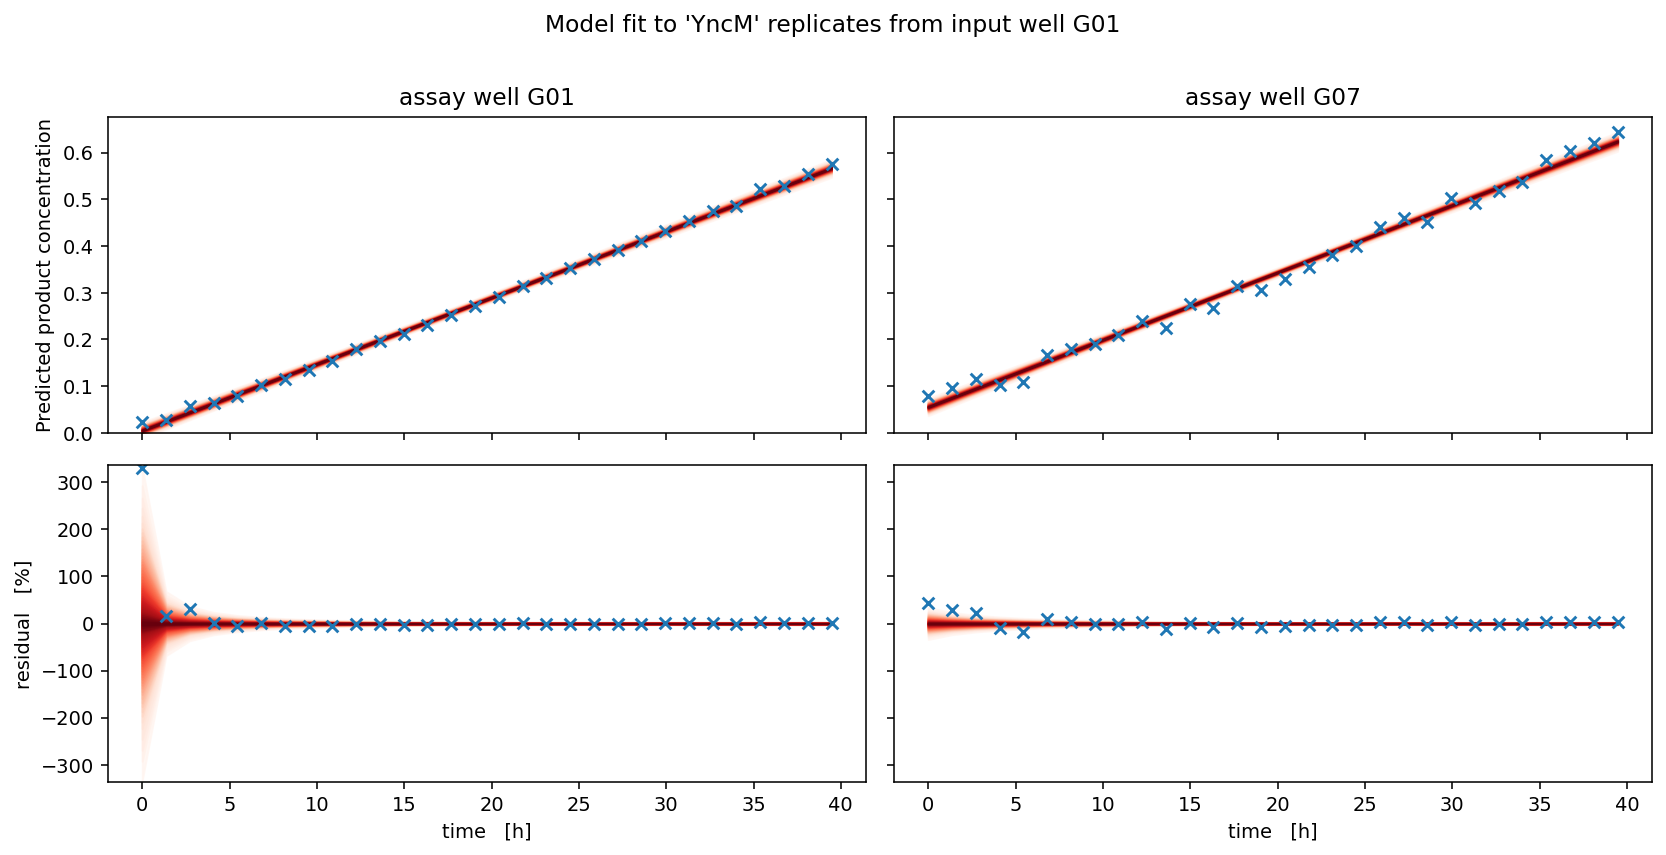

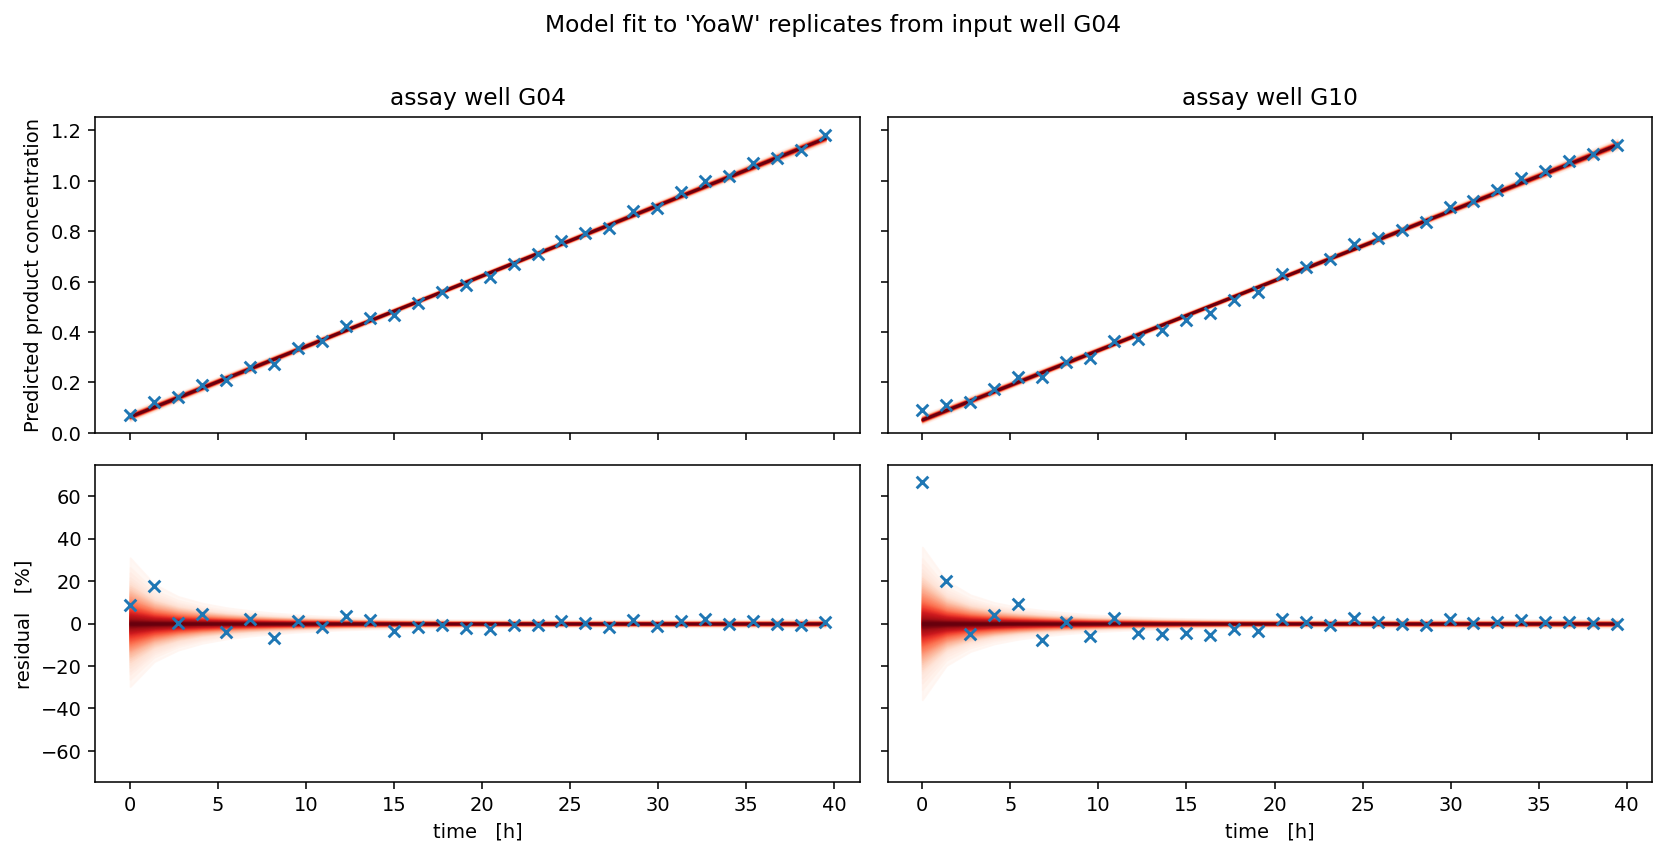

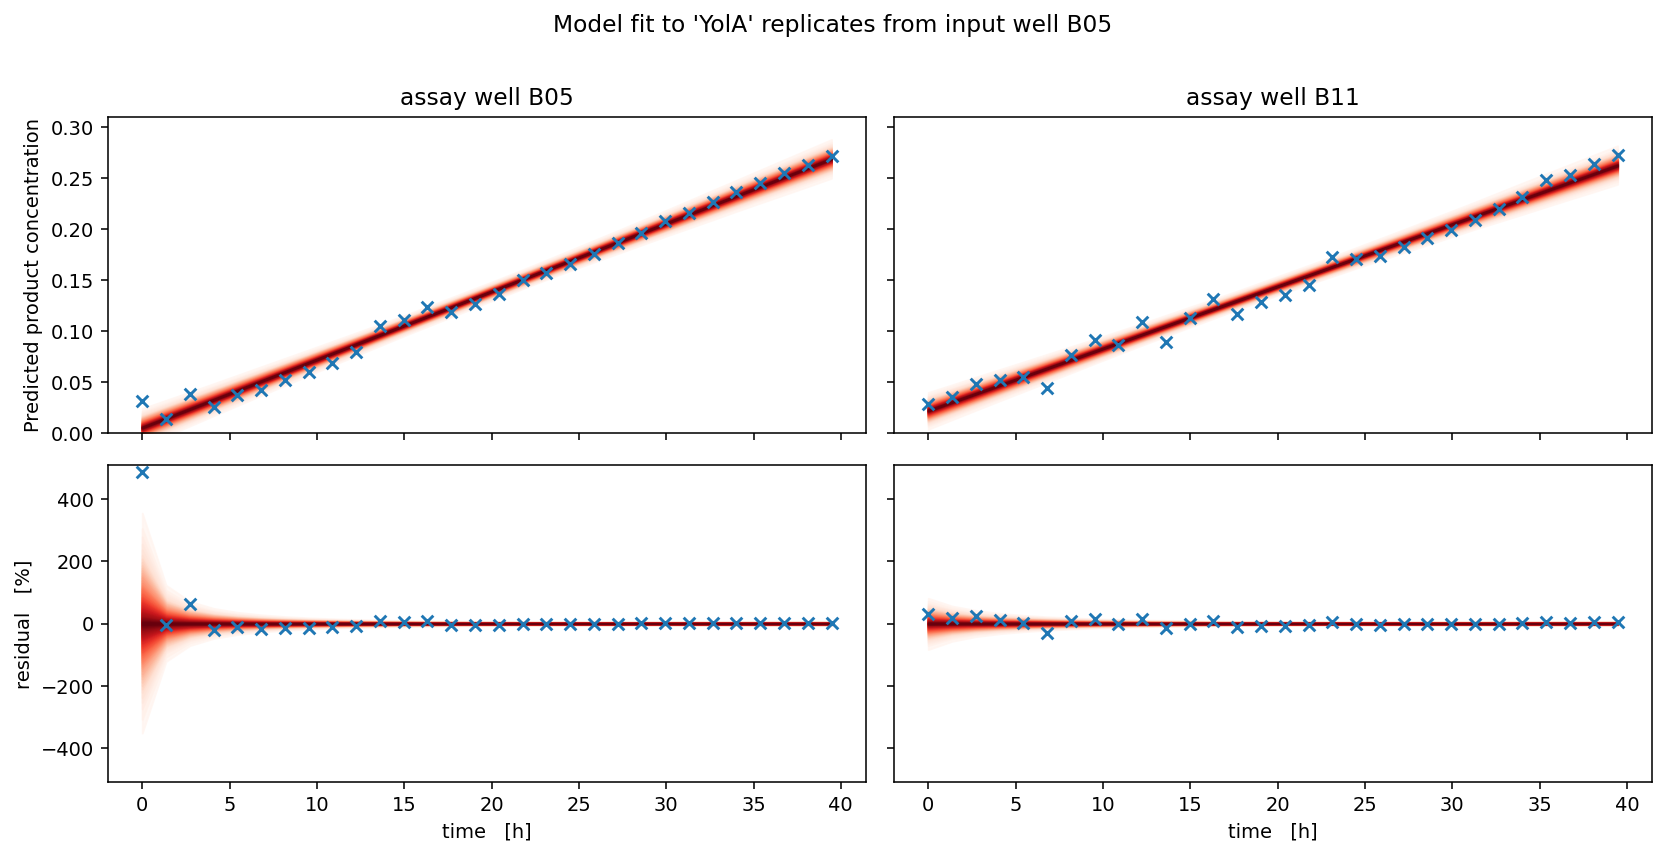

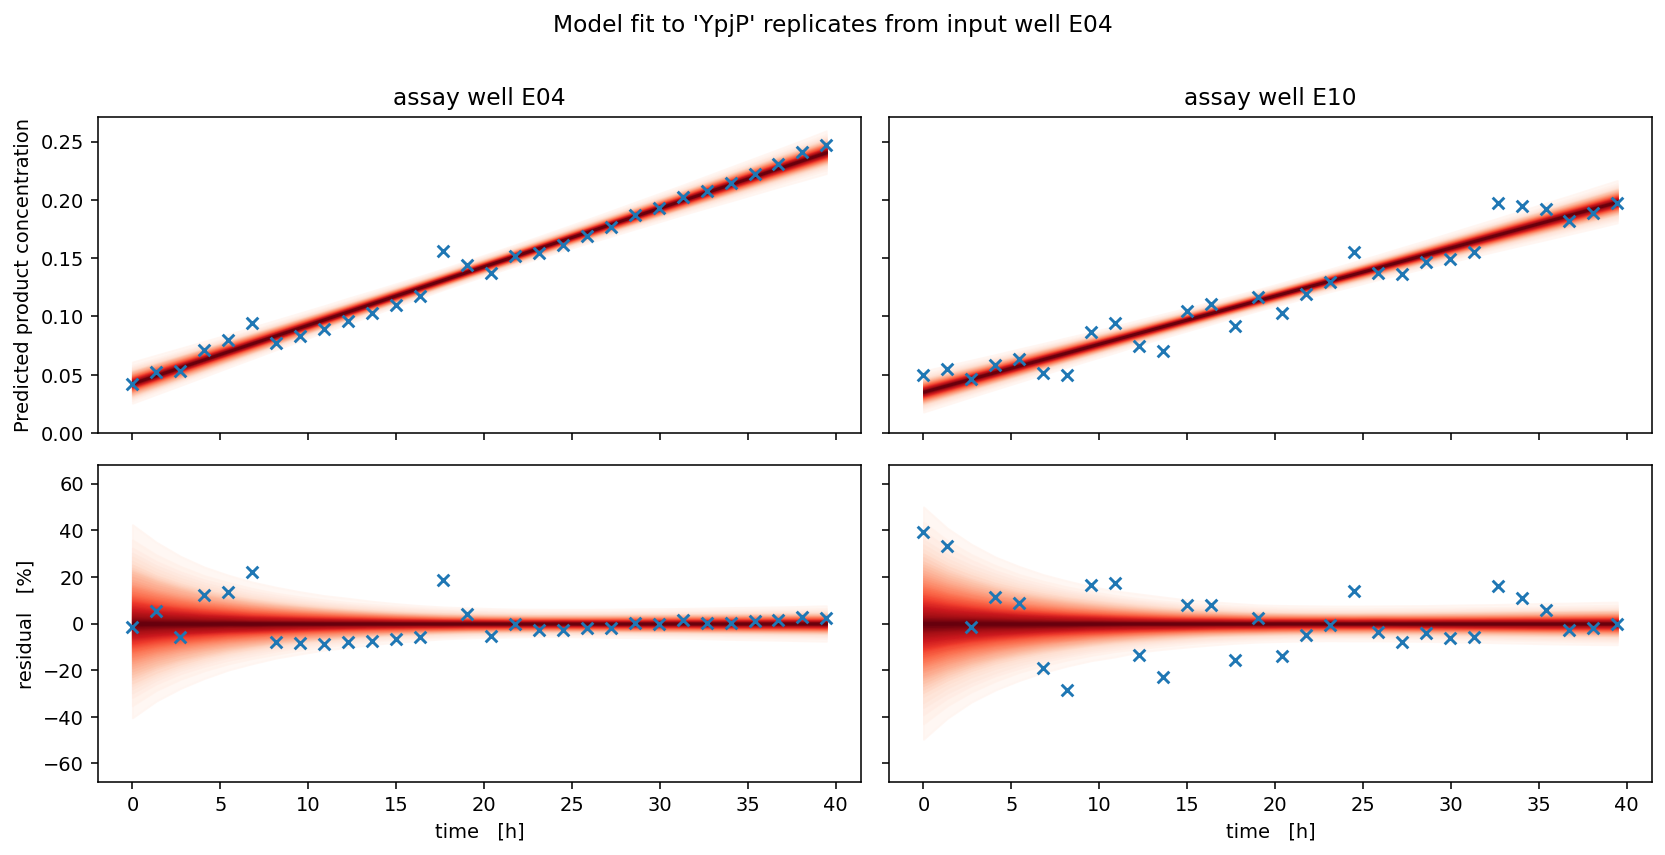

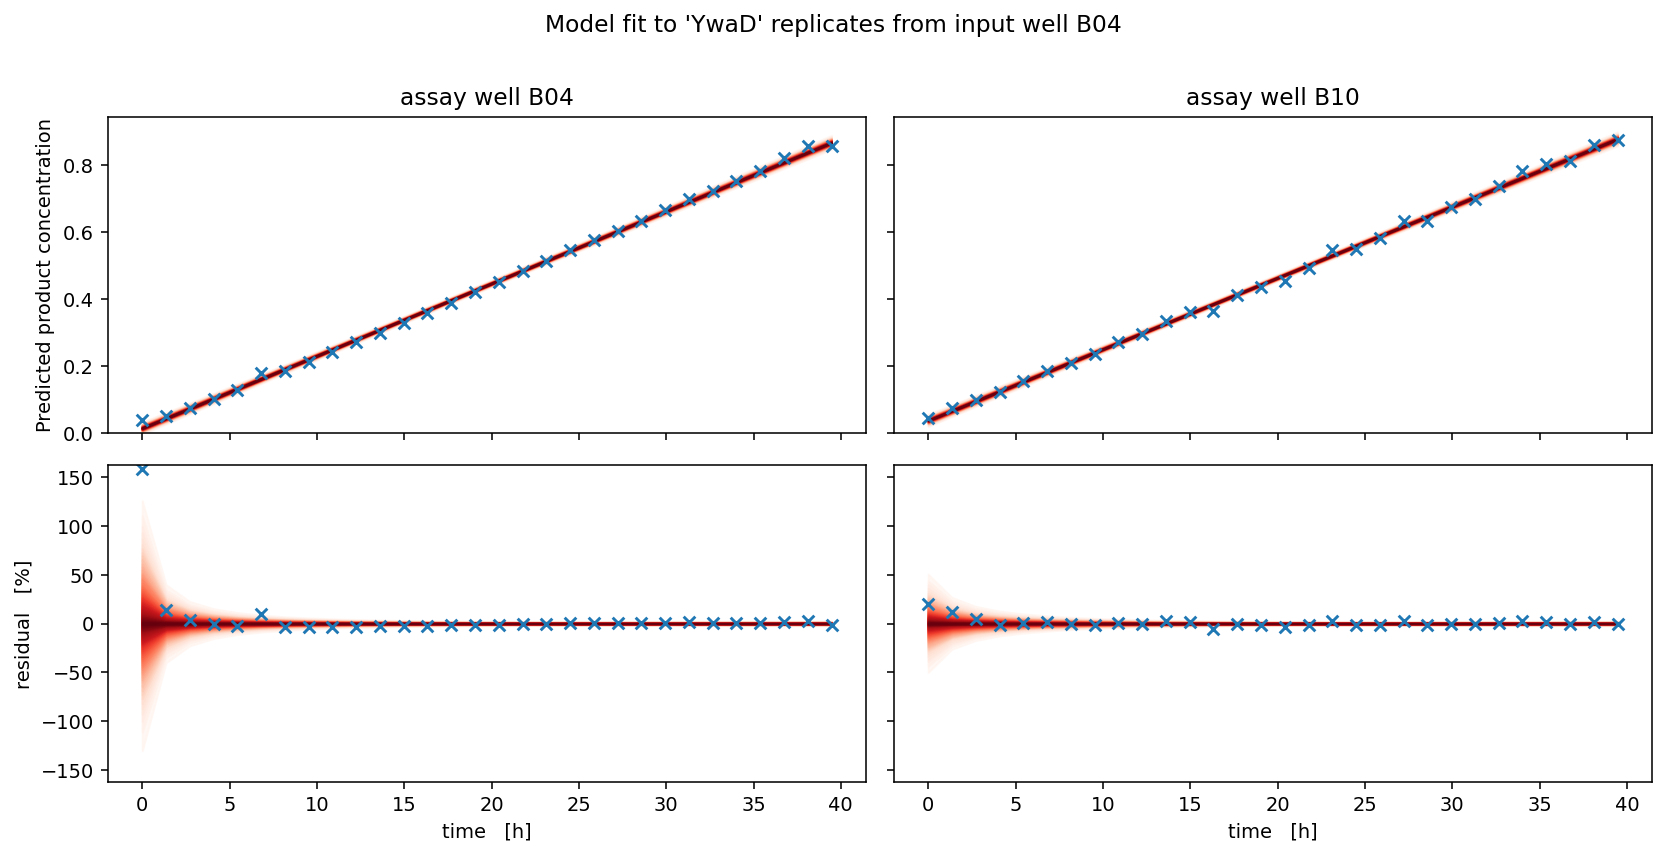

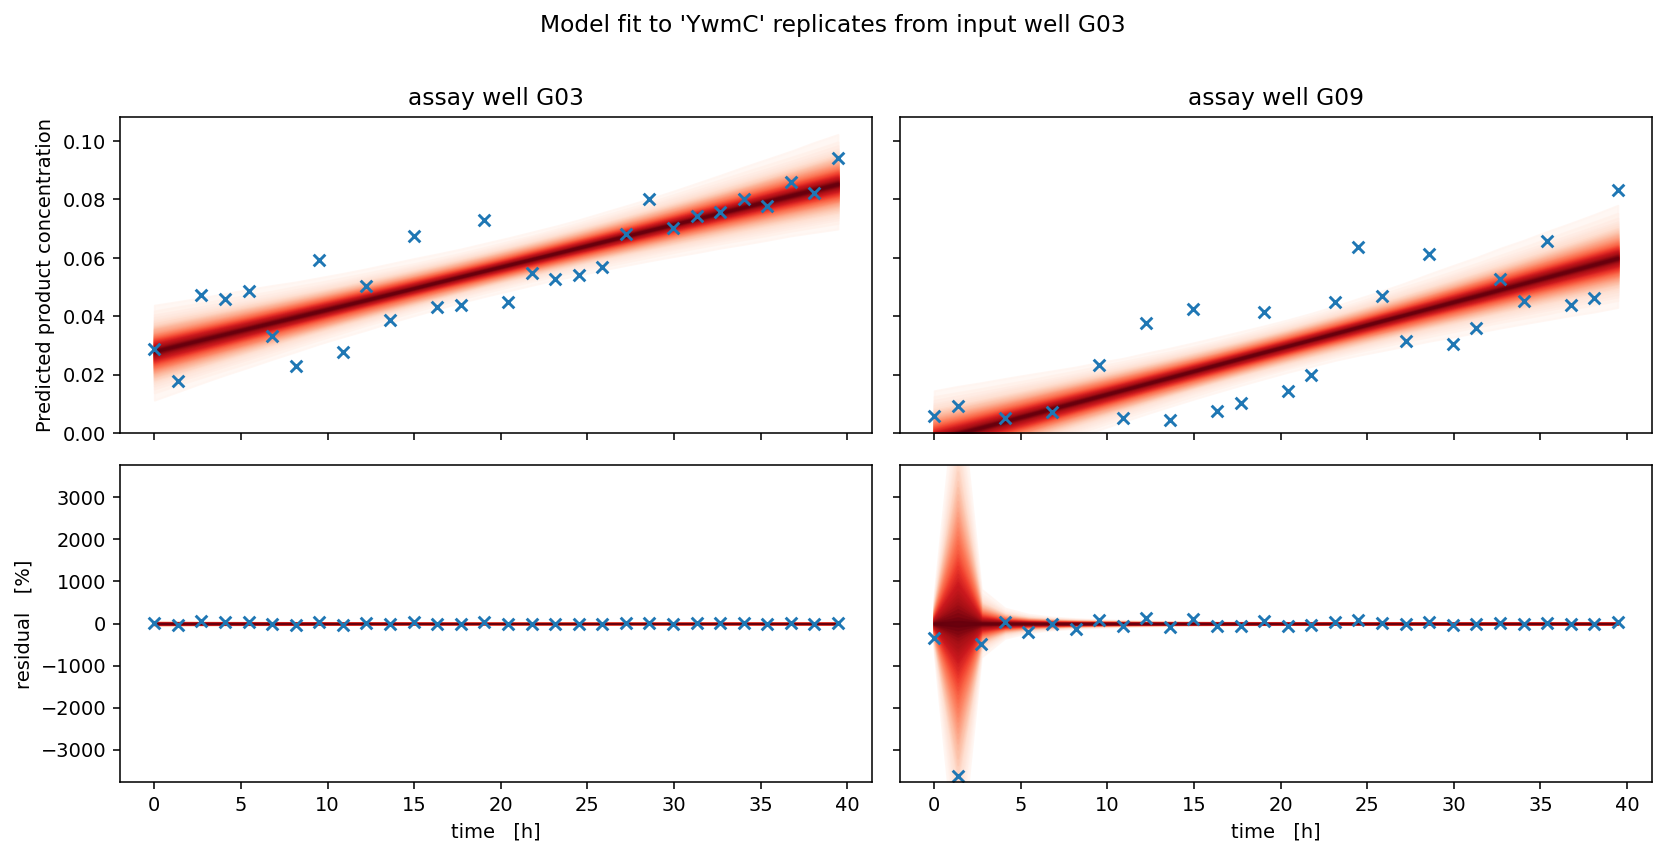

In [91]:
for sample_type in posterior.type.values:
    input_wells = df_inputs[df_inputs.type==sample_type].index.to_list()
    for input_well in input_wells:
        assay_wells = cutisplit.replicate_wells_from([input_well])
        vmax = posterior.vmax.sel(type=sample_type)
        cf_input = 1

        # figure constraints
        x_min = min(idata.constant_data.cutinase_time.values.flatten())
        x_max = max(idata.constant_data.cutinase_time.values.flatten())
        x_center = (x_min + x_max) / 2

        fig, axs = pyplot.subplots(
            dpi=140,
            figsize=(12, 6),
            nrows=2,
            ncols=2,
            sharey="row",
            sharex="col",
            squeeze=False,
        )

        residual_ptp = 0
        for c, assay_well in enumerate(assay_wells):
            vmax_input = vmax * cf_input
            vmax_assay = posterior.vmax_assay.sel(assay_well=assay_well)


            # and the actual product concentration
            pymc3.gp.util.plot_gp_dist(
                ax=axs[0, c],
                samples=posterior.product_concentration.sel(
                    assay_well=assay_well
                ).values.T,
                x=idata.constant_data.cutinase_time[0,:].values,
                samples_alpha=0,
            )
            axs[0, c].scatter(
                idata.constant_data.cutinase_time.values[0,:],
                cm_nitrophenol.predict_independent(
                    idata.constant_data.cutinase_absorbance.sel(assay_well=assay_well)
                ),
                marker="x",
            )

            # residuals for the product concentration
            samples = posterior.product_concentration.sel(assay_well=assay_well)
            median = samples.median("sample").values.T
            data = cm_nitrophenol.predict_independent(idata.constant_data.cutinase_absorbance.sel(assay_well=assay_well))
            rel_residuals = ((data - median) / median * 100).values
            residual_ptp = max(residual_ptp, numpy.ptp(rel_residuals))

            pymc3.gp.util.plot_gp_dist(
                ax=axs[1, c],
                samples=(samples.values.T - median) / median * 100,
                x=idata.constant_data.cutinase_time.values[0,:],
                samples_alpha=0,
            )
            axs[1, c].scatter(
                idata.constant_data.cutinase_time.values[0,:], rel_residuals, marker="x"
            )

            # formatting
            axs[0, c].set_title(f"assay well {assay_well}")
            axs[1, c].set_xlabel("time   [h]")
        axs[0, 0].set_ylim(0)
        axs[0, 0].set_ylabel(
            "Predicted product concentration"
        )
        axs[1, 0].set_ylim(-residual_ptp, residual_ptp)
        axs[1, 0].set_ylabel("residual   [%]")
        fig.suptitle(
            f"Model fit to '{sample_type}' replicates from input well {input_well}", y=1.01
        )
        fig.tight_layout()